# DCC-GARCH(1,1) model
- The parameters of individual GARCH and DCC-GARCH are reasonable 

- Strong correlations between residuals (not good)

In [ ]:
from IPython.display import display

import yfinance as yf
import pandas as pd
import numpy as np
import time

etf_tickers = ["SPY", "QQQ", "VTI", "XLK", "IWM"]  # Correlated subset
# etf_tickers = ["SPY", "TLT", "GLD", "XLE", "XLU"]  # Correlated subset

df = yf.download(etf_tickers, period="max", interval="1d", auto_adjust=False)["Adj Close"]
# df = yf.download(etf_tickers, start="2021-01-01", end="2024-12-31", interval="1d", auto_adjust=False)["Adj Close"]
returns = df.pct_change().dropna()
print(len(returns))

[*********************100%***********************]  20 of 20 completed

2384


In [8]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import yfinance as yf
from IPython.display import display
import time
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt
from arch import arch_model
import seaborn as sns
from scipy.stats import t

class DCC_GARCH:
    def __init__(self, returns):
        """Initialize DCC_GARCH with a DataFrame of asset returns."""
        self.index = returns.index
        self.returns = returns.values
        self.tickers = returns.columns
        self.n_assets = self.returns.shape[1]
        self.n_obs = self.returns.shape[0]
        self.garch_params = None
        self.dcc_params = None
        self.volatilities = None
        self.correlations = None
        self.residuals = None


    def fit_garch(self, ticker_idx):
        """Fit GARCH(1,1) to a single asset's returns."""
        returns = self.returns[:, ticker_idx]
        model = arch_model(returns, vol="Garch", p=1, q=1, rescale=True, dist="t", mean="Zero")
        res = model.fit(disp="off")
        res.params["omega"] /= (res.scale)**2
        return res
        # [res.params["omega"], res.params["alpha[1]"], res.params["beta[1]"]]


    def compute_volatility(self, returns, params):  # not in use anymore
        """Compute time-varying volatility from GARCH parameters."""
        omega, alpha, beta = params
        variance = np.zeros_like(returns)
        variance[0] = np.var(returns)
        for t in range(1, len(returns)):
            variance[t] = omega + alpha * returns[t-1]**2 + beta * variance[t-1]
        return np.sqrt(variance)


    def fit_dcc(self, residuals):
        """Fit DCC parameters to standardized residuals."""
        def dcc_log_likelihood(params, residuals):
            a, b = params
            if a < 0 or b < 0 or a + b >= 1:
                return np.inf
            n_obs, n_assets = residuals.shape
            Q_bar = np.cov(residuals.T)  # Unconditional covariance
            Qt = np.zeros((n_obs, n_assets, n_assets))
            Rt = np.zeros((n_obs, n_assets, n_assets))
            # print(Qt.shape, n_obs, n_assets)
            Qt[0] = Q_bar  # Initial Qt
            log_likelihood = 0
            for t in range(1, n_obs):
                Qt[t] = (1 - a - b) * Q_bar + a * np.outer(residuals[t-1], residuals[t-1]) + b * Qt[t-1]
                diag_sqrt = np.sqrt(np.diag(Qt[t]))
                Rt[t] = Qt[t] / np.outer(diag_sqrt, diag_sqrt)
                # Avoid singular matrices with small regularization
                Rt[t] += np.eye(n_assets) * 1e-4
                try:
                    chol = np.linalg.cholesky(Rt[t])  # Ensure positive definiteness
                    log_likelihood -= 0.5 * (np.log(np.linalg.det(Rt[t])) + 
                                            residuals[t].T @ np.linalg.inv(Rt[t]) @ residuals[t])
                except np.linalg.LinAlgError:
                    return np.inf  # Penalize if matrix is singular
            return -log_likelihood
        
        initial_guesses = [[0.01, 0.95], [0.05, 0.9], [0.02, 0.93]]
        bounds = [(1e-6, 0.2), (0.7, 0.95)]  # Tighter, realistic ranges
        best_result = None
        best_ll = np.inf
        for init in initial_guesses:
            result = minimize(dcc_log_likelihood, init, args=(residuals,), 
                            method="SLSQP", bounds=bounds, options={"ftol": 1e-8, "maxiter": 2000})
            if result.fun < best_ll:
                best_ll = result.fun
                best_result = result
        print(f"DCC Fit Success: {best_result.success}, Message: {best_result.message}")
        return best_result.x


    def fit(self):
        """Fit the full DCC-GARCH model."""
        print("Fitting GARCH models...")
        self.garch_params = []
        self.volatilities = np.zeros_like(self.returns)
        self.residuals = np.zeros_like(self.returns)
        for i in range(self.n_assets):
            res = self.fit_garch(i)
            params = [res.params["omega"], res.params["alpha[1]"], res.params["beta[1]"]]
            self.garch_params.append(params)
            # self.volatilities[:, i] = res.conditional_volatility  # Use arch’s volatility
            # self.residuals[:, i] = res.resid / res.conditional_volatility  # Standardized residuals
            self.volatilities[:, i] = res.conditional_volatility / res.scale
            self.residuals[:, i] = res.resid / res.conditional_volatility

        print("Fitting DCC model...")
        self.dcc_params = self.fit_dcc(self.residuals)
        a, b = self.dcc_params
        Q_bar = np.cov(self.residuals.T)
        self.correlations = np.zeros((self.n_obs, self.n_assets, self.n_assets))
        Qt = np.zeros_like(self.correlations)
        Qt[0] = Q_bar
        for t in range(1, self.n_obs):
            Qt[t] = (1 - a - b) * Q_bar + a * np.outer(self.residuals[t-1], self.residuals[t-1]) + b * Qt[t-1]
            diag_sqrt = np.sqrt(np.diag(Qt[t]))
            self.correlations[t] = Qt[t] / np.outer(diag_sqrt, diag_sqrt)
            # Ensure positive definiteness
            self.correlations[t] += np.eye(self.n_assets) * 1e-6
        

    def get_volatilities(self): 
        """Return time-varying volatilities as a DataFrame."""
        if self.volatilities is None:
            raise ValueError("Model not fitted yet. Call fit() first.")
        return pd.DataFrame(self.volatilities, index=self.index, columns=self.tickers)


    def get_correlations(self):
        """Return time-varying correlation matrices as a list of DataFrames."""
        if self.correlations is None:
            raise ValueError("Model not fitted yet. Call fit() first.")
        return [pd.DataFrame(self.correlations[t], index=self.tickers, columns=self.tickers) 
                for t in range(self.n_obs)]
        
        
    def diagnostics(self):
        """Perform diagnostic checks on the model fit."""
        if self.residuals is None:
            raise ValueError("Model not fitted yet. Call fit() first.")

        print("=== Residual Sanity Check ===")
        print(f"Residuals shape: {self.residuals.shape}")
        print(f"Sample residuals (first 5 rows):")
        display(pd.DataFrame(self.residuals[:5], columns=self.tickers))

        print("=== Univariate GARCH Diagnostics ===")
        for i, ticker in enumerate(self.tickers):
            res = self.residuals[:, i]
            mean_res = np.mean(res)
            var_res = np.var(res)
            lb_test = acorr_ljungbox(res, lags=[10], return_df=True)
            lb_test_sq = acorr_ljungbox(res**2, lags=[10], return_df=True)
            print(f"\n{ticker}:")
            print(f"Mean of residuals: {mean_res:.4f} (should be ~0)")
            print(f"Variance of residuals: {var_res:.4f} (should be ~1)")
            print(f"Ljung-Box test (residuals, lag 10): p-value = {lb_test['lb_pvalue'].iloc[0]:.4f}")
            print(f"Ljung-Box test (squared residuals, lag 10): p-value = {lb_test_sq['lb_pvalue'].iloc[0]:.4f}")
            print(f"omega = {self.garch_params[i][0]:.6f}, alpha = {self.garch_params[i][1]:.4f}, beta = {self.garch_params[i][2]:.4f}")
            

        print("\n=== DCC Correlation Diagnostics ===")
        print("DCC Parameters [a, b]:", self.dcc_params)
        # Create a matrix for p-values
        n_assets = self.n_assets
        p_value_matrix = np.ones((n_assets, n_assets))  # Default to 1 (no significance)
        for i in range(n_assets):
            for j in range(i + 1, n_assets):
                cross_prod = self.residuals[:, i] * self.residuals[:, j]
                lb_cross = acorr_ljungbox(cross_prod, lags=[10], return_df=True)
                p_val = lb_cross['lb_pvalue'].iloc[0]
                p_value_matrix[i, j] = p_val
                p_value_matrix[j, i] = p_val  # Symmetric matrix
                if p_val < 0.05:
                    print(f"Significant residual cross-correlation between {self.tickers[i]} and {self.tickers[j]}: "f"p-value = {p_val:.4f}")
        # Heatmap of p-values
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            p_value_matrix,
            annot=True,  # Show p-values in cells
            fmt=".4f",   # 4 decimal places
            cmap="RdYlGn",  # Red (low p) to Green (high p), reversed
            vmin=0, vmax=1,  # p-value range
            xticklabels=self.tickers,
            yticklabels=self.tickers,
            square=True
        )
        plt.title("DCC Residual Cross-Correlation P-Values (Lag 10)")
        plt.show()
        
        print("\n=== Average Correlation Matrix ===")
        avg_corr = np.mean([self.correlations[t] for t in range(self.n_obs)], axis=0)
        display(pd.DataFrame(avg_corr, index=self.tickers, columns=self.tickers).round(4))


    def plot_diagnostics(self, ticker_idx=0):
        """Plot diagnostics for a specific asset, including histogram of standardized residuals."""
        ticker = self.tickers[ticker_idx]
        res = self.residuals[:, ticker_idx]
        vols = self.volatilities[:, ticker_idx]
        rets = self.returns[:, ticker_idx]

        # Fit t-distribution to residuals
        df, loc, scale = t.fit(res)  # Degrees of freedom, location (mean), scale (std)
        
        plt.figure(figsize=(12, 10))  # Increased height for 4 subplots

        # Subplot 1: Returns vs. Fitted Volatility
        plt.subplot(4, 1, 1)
        plt.plot(self.index, rets, label="Returns")
        plt.plot(self.index, vols, label="Fitted Volatility", color="orange")
        plt.fill_between(self.index, -vols, vols, color="orange", alpha=0.2, label="Volatility Band")
        plt.title(f"{ticker}: Returns vs. Fitted Volatility")
        plt.legend()

        # Subplot 2: Standardized Residuals Time Series
        plt.subplot(4, 1, 2)
        plt.plot(self.index, res, label="Standardized Residuals")
        plt.axhline(0, color="black", linestyle="--")
        plt.axhline(2, color="red", linestyle="--", alpha=0.5)
        plt.axhline(-2, color="red", linestyle="--", alpha=0.5)
        plt.title(f"{ticker}: Standardized Residuals")
        plt.legend()

        # Subplot 3: ACF of Squared Residuals
        plt.subplot(4, 1, 3)
        pd.plotting.autocorrelation_plot(res**2)
        plt.xlim(0, 50)
        plt.title(f"{ticker}: ACF of Squared Residuals")

        # Subplot 4: Histogram of Standardized Residuals
        plt.subplot(4, 1, 4)
        plt.hist(res, bins=50, density=True, alpha=0.7, color="blue", label="Residuals")
        x = np.linspace(min(res), max(res), 100)
        plt.plot(x, t.pdf(x, df, loc, scale), "r-", lw=2, label=f"t-dist (df={df:.1f})")
        plt.axvline(0, color="black", linestyle="--")
        plt.title(f"{ticker}: Histogram of Standardized Residuals")
        plt.legend()

        plt.tight_layout()
        plt.show()

Starting DCC-GARCH fitting...
Fitting GARCH models...
Fitting DCC model...
DCC Fit Success: True, Message: Optimization terminated successfully
DCC-GARCH fitting completed in 41.86 seconds.
=== Residual Sanity Check ===
Residuals shape: (2384, 20)
Sample residuals (first 5 rows):


Ticker       EEM       GLD       IWM       LQD       QQQ       SPY       TLT  \
0       0.293676  1.825606  0.172601  0.142699  0.443842  0.073124  0.385517   
1      -0.642549  0.437035 -0.132999  1.387207  0.249862  0.124315  1.142069   
2      -1.435961  0.553029 -1.293351 -0.251846 -0.696459 -0.889161  0.251600   
3       0.639242  1.977888 -0.895301  1.332884 -0.176382 -0.676502  1.324099   
4       2.090492 -0.490647  2.188166 -0.138361  1.904083  2.227264 -0.718911   

Ticker       USO       VTI      VXUS       XLB       XLE       XLF       XLI  \
0      -0.139180  0.164595  0.311408 -0.046255 -0.429814 -0.593007  0.375634   
1      -1.988625  0.025083 -0.805350 -0.922604 -0.878168  0.082976  0.021717   
2      -0.678548 -1.020816 -1.695455 -0.415656 -0.713825 -0.799563 -1.300615   
3      -0.028354 -0.704227  0.606551  0.890591  0.597894 -0.857004 -1.247632   
4       0.238278  2.121102  1.995759  0.302830  1.271564  2.362678  1.208442   

Ticker       XLK       XLP      XLRE       XLU       XLV       XLY  
0       0.433068  0.280352 -0.166233 -0.511714  0.404069  0.136798  
1       0.124964  0.347917  0.657198  0.980222  0.244959  0.592434  
2      -0.236942 -0.838544 -0.665667 -0.248150 -1.229746 -0.689171  
3      -0.221539 -1.617893  0.000000 -0.025753 -0.183896 -1.329958  
4       1.542648  1.155374 -0.335330  1.733418  2.255979  1.604603

=== Univariate GARCH Diagnostics ===

EEM:
Mean of residuals: 0.0175 (should be ~0)
Variance of residuals: 0.9998 (should be ~1)
Ljung-Box test (residuals, lag 10): p-value = 0.4701
Ljung-Box test (squared residuals, lag 10): p-value = 0.4999
omega = 0.000008, alpha = 0.1140, beta = 0.8315

GLD:
Mean of residuals: 0.0509 (should be ~0)
Variance of residuals: 0.9896 (should be ~1)
Ljung-Box test (residuals, lag 10): p-value = 0.3123
Ljung-Box test (squared residuals, lag 10): p-value = 0.3932
omega = 0.000001, alpha = 0.0396, beta = 0.9484

IWM:
Mean of residuals: 0.0219 (should be ~0)
Variance of residuals: 1.0023 (should be ~1)
Ljung-Box test (residuals, lag 10): p-value = 0.8458
Ljung-Box test (squared residuals, lag 10): p-value = 0.9028
omega = 0.000003, alpha = 0.0962, beta = 0.8935

LQD:
Mean of residuals: 0.0366 (should be ~0)
Variance of residuals: 1.0033 (should be ~1)
Ljung-Box test (residuals, lag 10): p-value = 0.0350
Ljung-Box test (squared residuals, lag 10): p-value = 0.

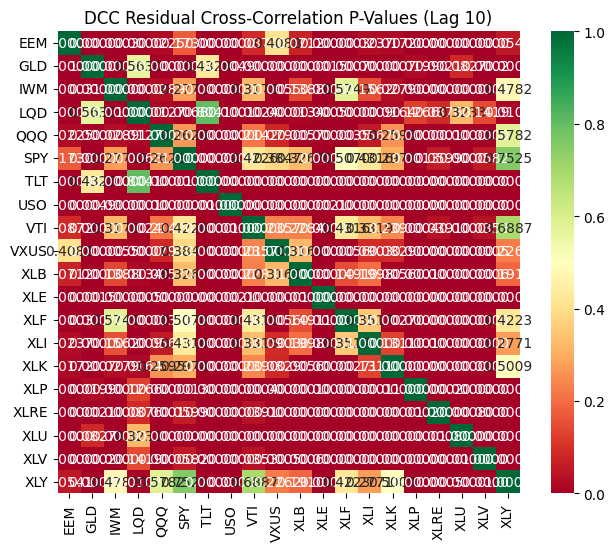


=== Average Correlation Matrix ===


Ticker     EEM     GLD     IWM     LQD     QQQ     SPY     TLT     USO  \
Ticker                                                                   
EEM     0.9996  0.1790  0.6282  0.1870  0.6679  0.6982 -0.1003  0.2950   
GLD     0.1790  0.9996  0.0140  0.3732  0.0277  0.0255  0.3406  0.1054   
IWM     0.6282  0.0140  0.9996  0.1367  0.6973  0.8220 -0.1663  0.2790   
LQD     0.1870  0.3732  0.1367  0.9996  0.1984  0.1793  0.8159 -0.0501   
QQQ     0.6679  0.0277  0.6973  0.1984  0.9996  0.9067 -0.0889  0.1812   
SPY     0.6982  0.0255  0.8220  0.1793  0.9067  0.9996 -0.1481  0.2676   
TLT    -0.1003  0.3406 -0.1663  0.8159 -0.0889 -0.1481  0.9996 -0.2047   
USO     0.2950  0.1054  0.2790 -0.0501  0.1812  0.2676 -0.2047  0.9996   
VTI     0.7062  0.0283  0.8689  0.1812  0.8983  0.9926 -0.1475  0.2726   
VXUS    0.8968  0.1797  0.7281  0.2079  0.7140  0.8040 -0.1162  0.3185   
XLB     0.6339  0.1095  0.7481  0.1262  0.5755  0.7585 -0.1668  0.2883   
XLE     0.4563  0.0476  0.5585 -0.0260  0.3222  0.5079 -0.2525  0.6684   
XLF     0.5323 -0.1053  0.7583 -0.0180  0.5534  0.7658 -0.3064  0.2466   
XLI     0.5918  0.0002  0.8036  0.1090  0.6378  0.8304 -0.1933  0.2698   
XLK     0.6512  0.0173  0.6772  0.1860  0.9660  0.8966 -0.1015  0.1853   
XLP     0.3596  0.0774  0.4233  0.2279  0.4226  0.5724  0.0239  0.1007   
XLRE    0.3905  0.1387  0.5195  0.3645  0.4264  0.5470  0.1580  0.0968   
XLU     0.2169  0.1847  0.2763  0.3327  0.2223  0.3528  0.1941  0.0514   
XLV     0.4619  0.0334  0.5916  0.1709  0.5961  0.7092 -0.0742  0.1308   
XLY     0.6366 -0.0053  0.7609  0.1855  0.8330  0.8599 -0.1079  0.1852   

Ticker     VTI    VXUS     XLB     XLE     XLF     XLI     XLK     XLP  \
Ticker                                                                   
EEM     0.7062  0.8968  0.6339  0.4563  0.5323  0.5918  0.6512  0.3596   
GLD     0.0283  0.1797  0.1095  0.0476 -0.1053  0.0002  0.0173  0.0774   
IWM     0.8689  0.7281  0.7481  0.5585  0.7583  0.8036  0.6772  0.4233   
LQD     0.1812  0.2079  0.1262 -0.0260 -0.0180  0.1090  0.1860  0.2279   
QQQ     0.8983  0.7140  0.5755  0.3222  0.5534  0.6378  0.9660  0.4226   
SPY     0.9926  0.8040  0.7585  0.5079  0.7658  0.8304  0.8966  0.5724   
TLT    -0.1475 -0.1162 -0.1668 -0.2525 -0.3064 -0.1933 -0.1015  0.0239   
USO     0.2726  0.3185  0.2883  0.6684  0.2466  0.2698  0.1853  0.1007   
VTI     0.9996  0.8106  0.7698  0.5209  0.7745  0.8402  0.8844  0.5516   
VXUS    0.8106  0.9996  0.7419  0.5301  0.6587  0.7167  0.7008  0.4716   
XLB     0.7698  0.7419  0.9996  0.5711  0.7198  0.8202  0.5820  0.5087   
XLE     0.5209  0.5301  0.5711  0.9996  0.5642  0.5617  0.3265  0.2705   
XLF     0.7745  0.6587  0.7198  0.5642  0.9996  0.7975  0.5508  0.4548   
XLI     0.8402  0.7167  0.8202  0.5617  0.7975  0.9996  0.6484  0.5193   
XLK     0.8844  0.7008  0.5820  0.3265  0.5508  0.6484  0.9996  0.4085   
XLP     0.5516  0.4716  0.5087  0.2705  0.4548  0.5193  0.4085  0.9996   
XLRE    0.5540  0.4762  0.4788  0.2597  0.4060  0.5019  0.4222  0.5837   
XLU     0.3418  0.2939  0.3227  0.1769  0.2456  0.3359  0.2233  0.5920   
XLV     0.7034  0.5751  0.5643  0.3381  0.5546  0.5954  0.5626  0.5785   
XLY     0.8675  0.7080  0.6418  0.3854  0.6409  0.7027  0.7696  0.4726   

Ticker    XLRE     XLU     XLV     XLY  
Ticker                                  
EEM     0.3905  0.2169  0.4619  0.6366  
GLD     0.1387  0.1847  0.0334 -0.0053  
IWM     0.5195  0.2763  0.5916  0.7609  
LQD     0.3645  0.3327  0.1709  0.1855  
QQQ     0.4264  0.2223  0.5961  0.8330  
SPY     0.5470  0.3528  0.7092  0.8599  
TLT     0.1580  0.1941 -0.0742 -0.1079  
USO     0.0968  0.0514  0.1308  0.1852  
VTI     0.5540  0.3418  0.7034  0.8675  
VXUS    0.4762  0.2939  0.5751  0.7080  
XLB     0.4788  0.3227  0.5643  0.6418  
XLE     0.2597  0.1769  0.3381  0.3854  
XLF     0.4060  0.2456  0.5546  0.6409  
XLI     0.5019  0.3359  0.5954  0.7027  
XLK     0.4222  0.2233  0.5626  0.7696  
XLP     0.5837  0.5920  0.5785  0.4726  
XLRE

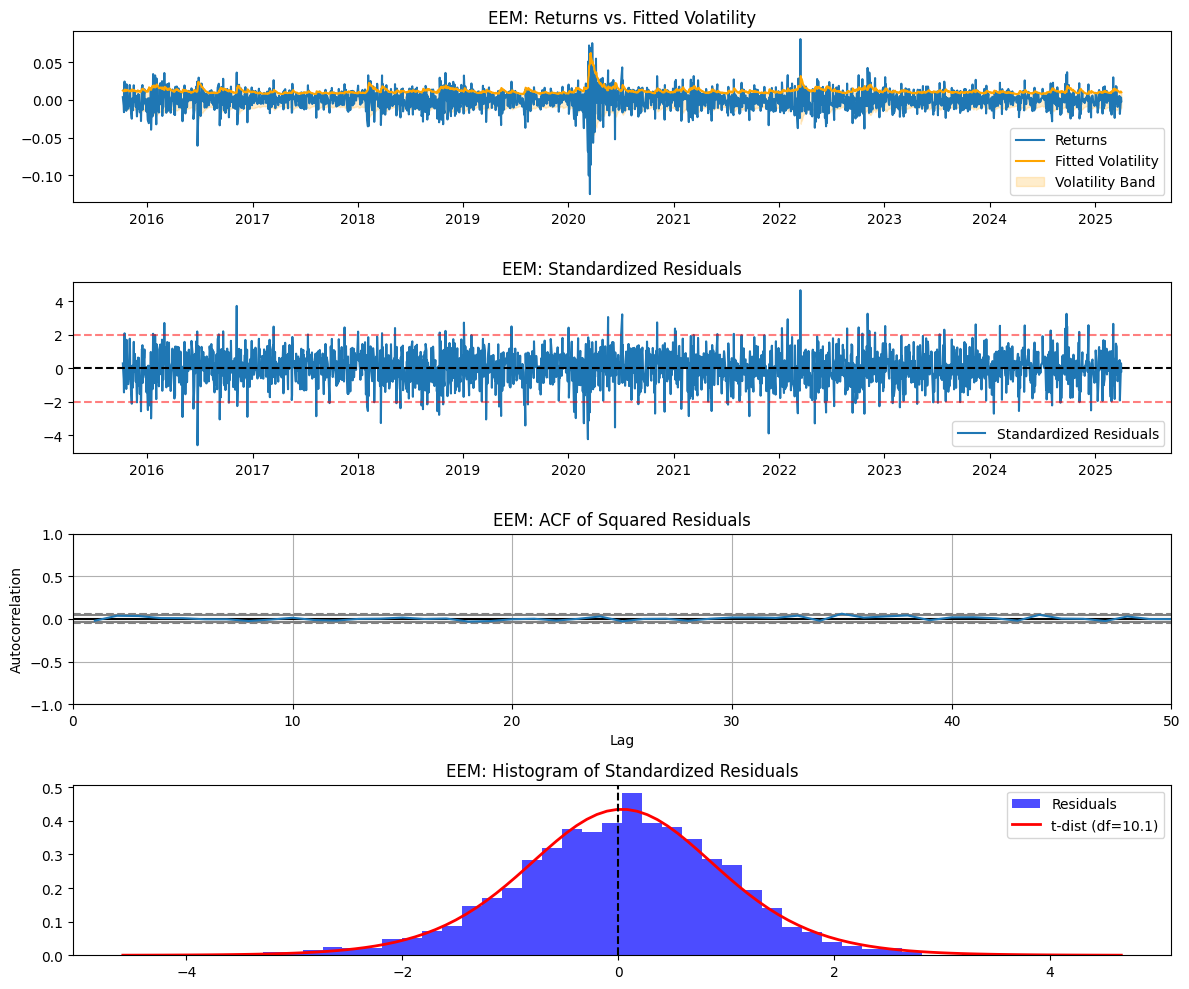

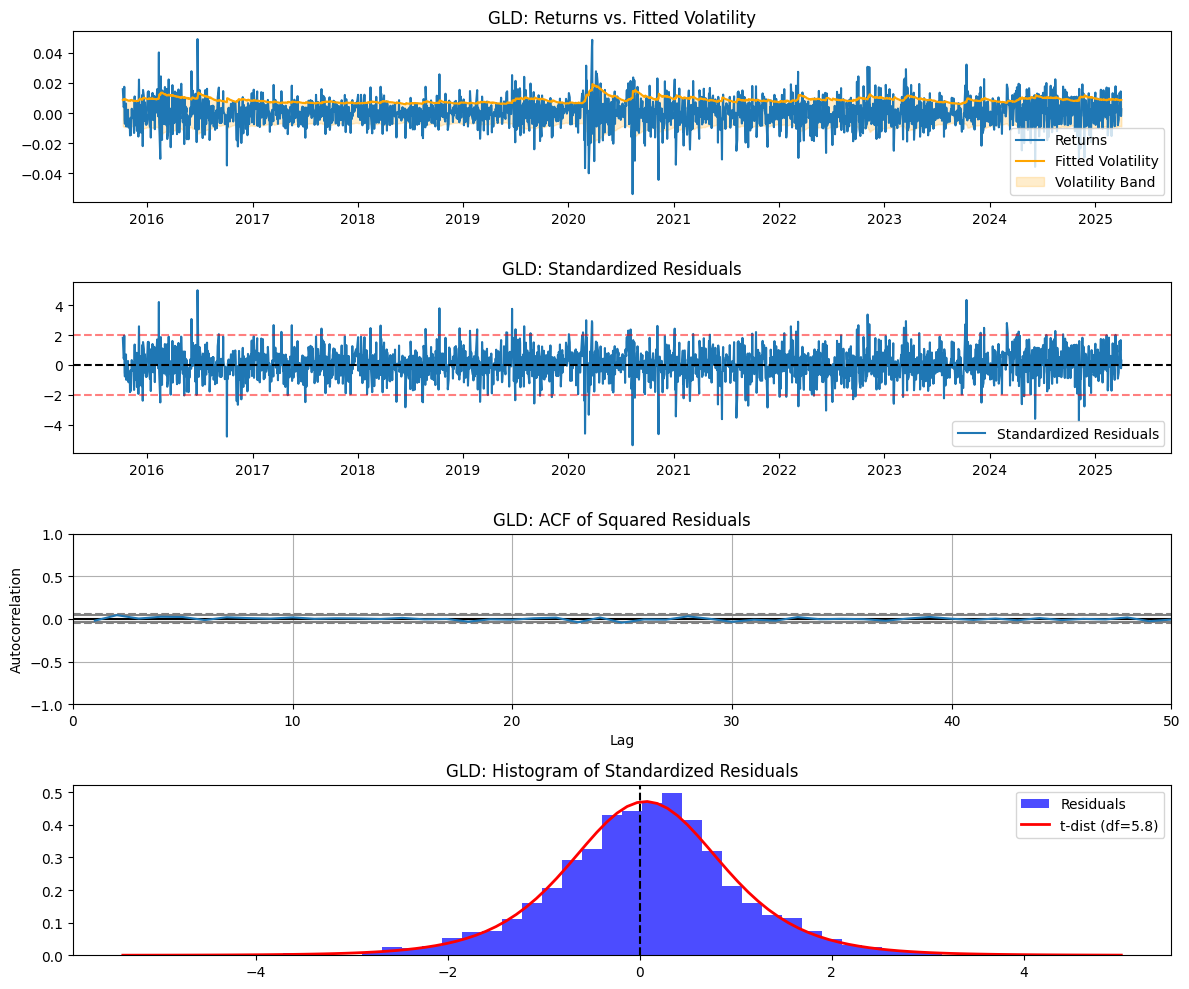

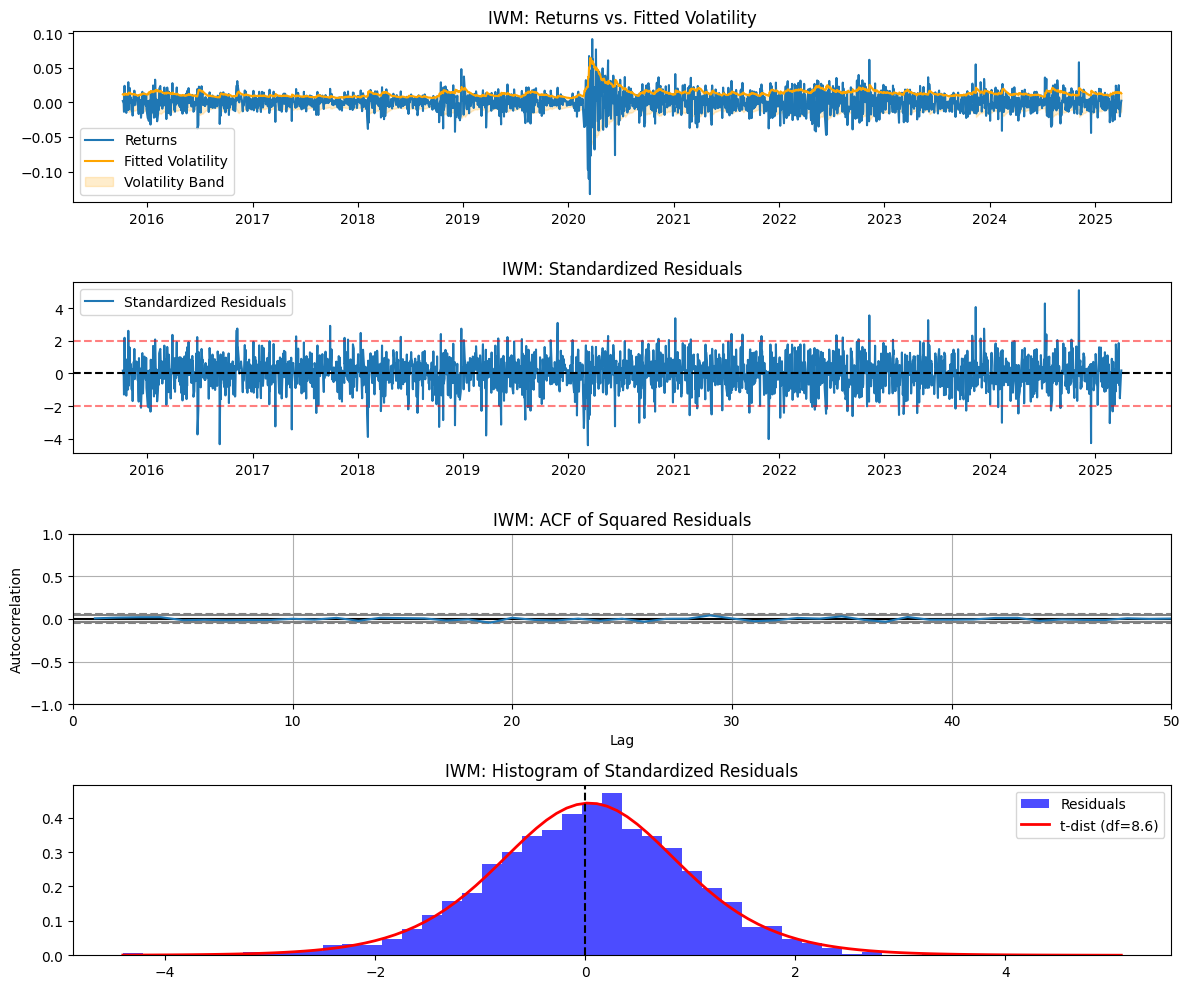

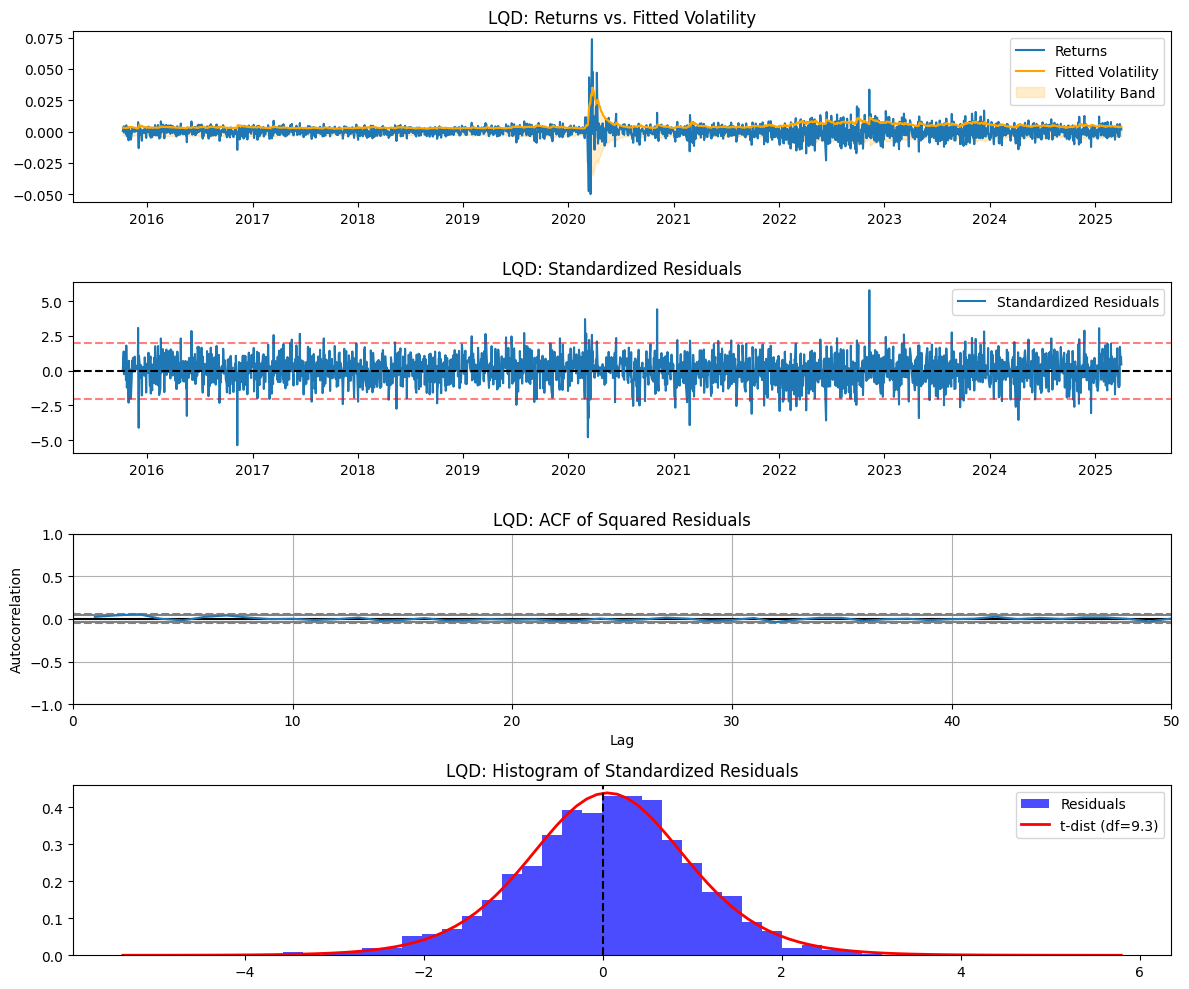

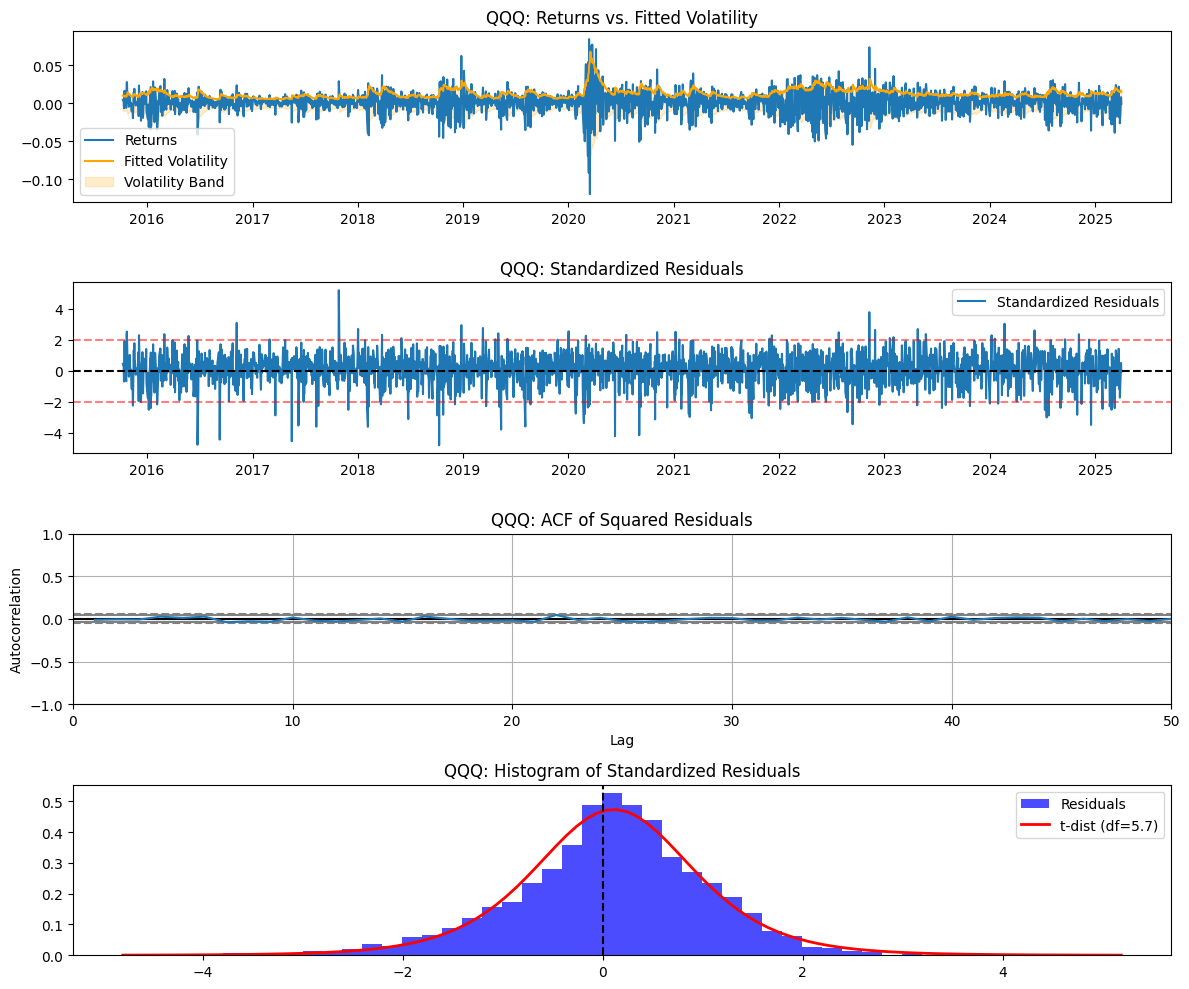

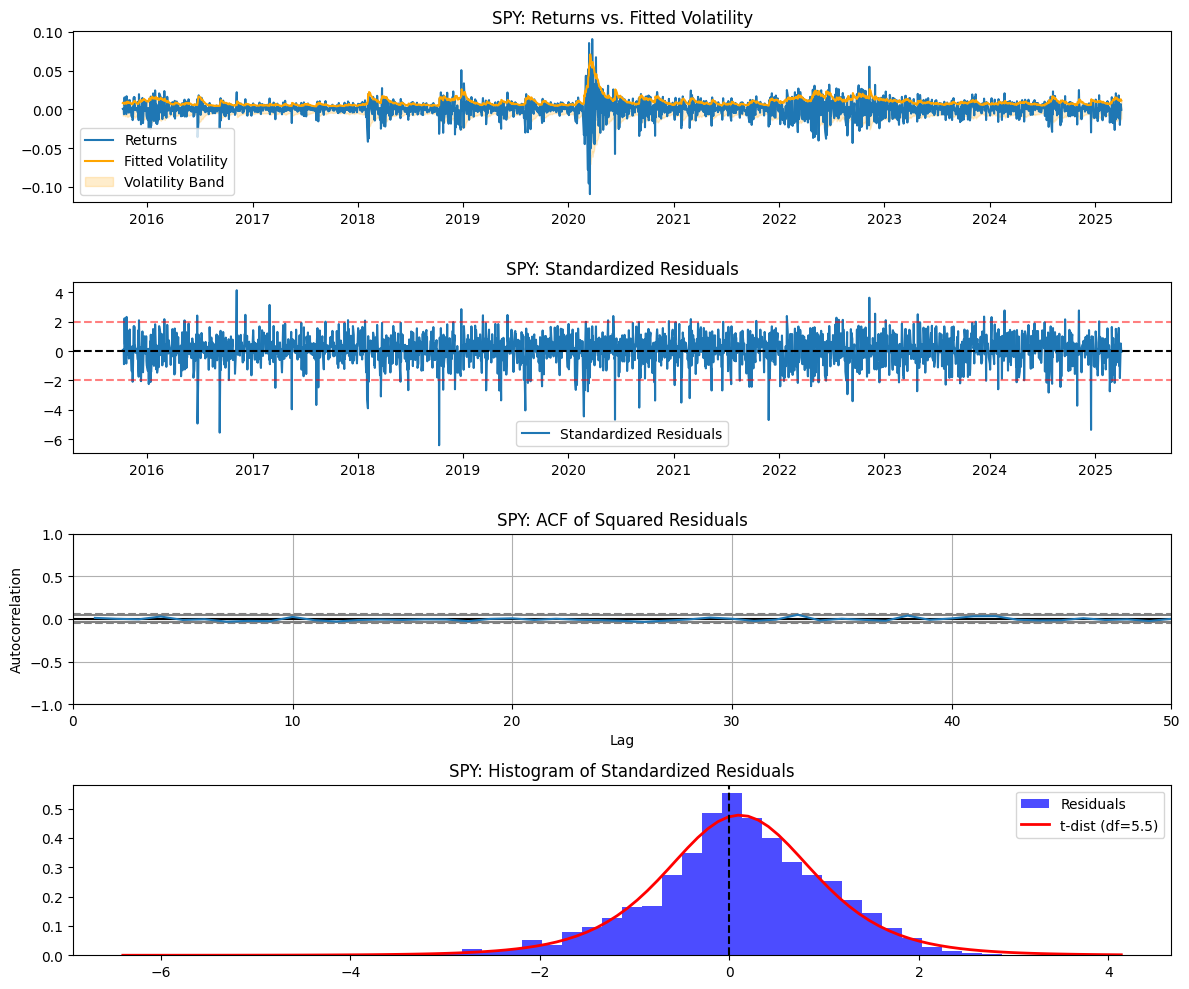

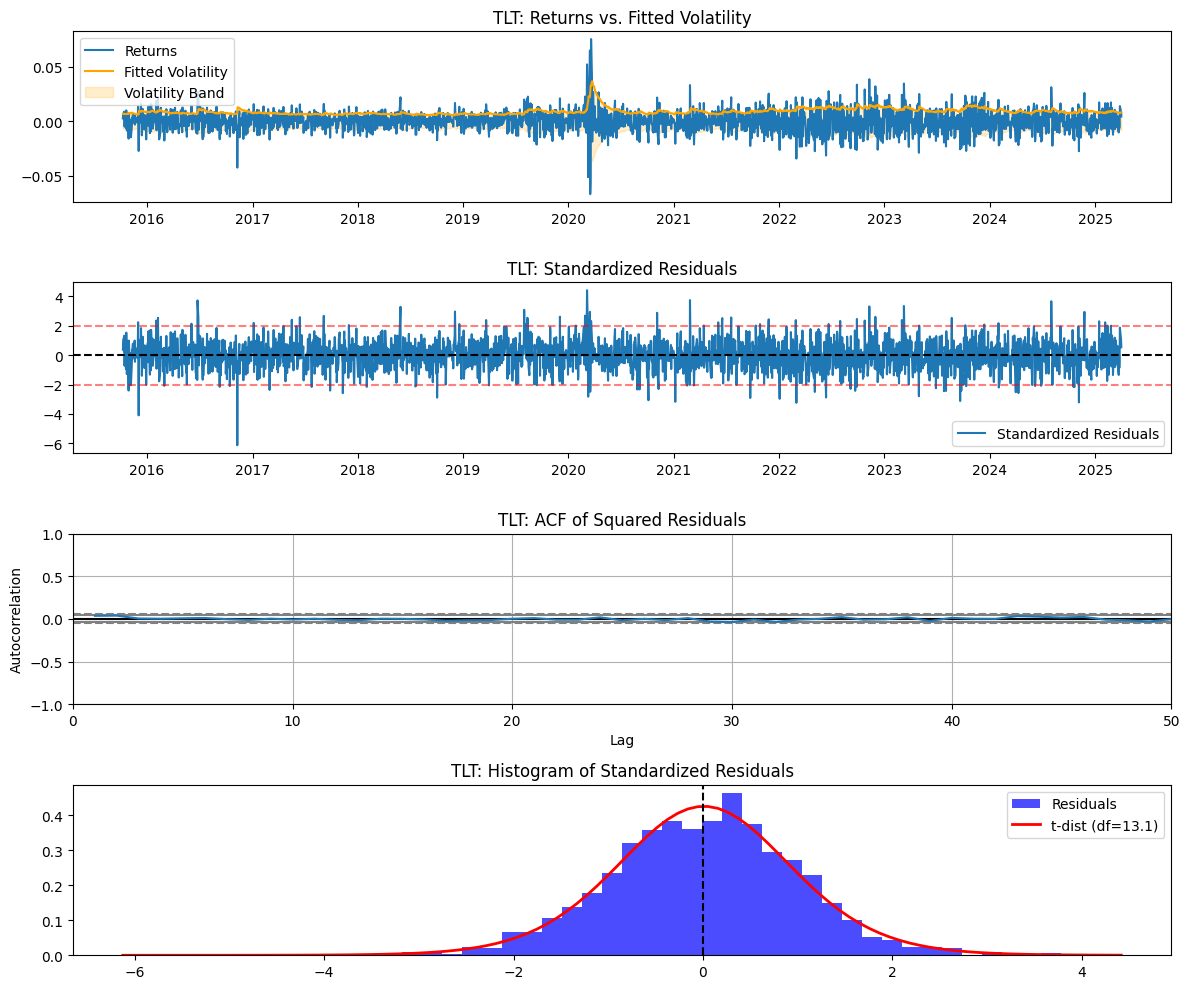

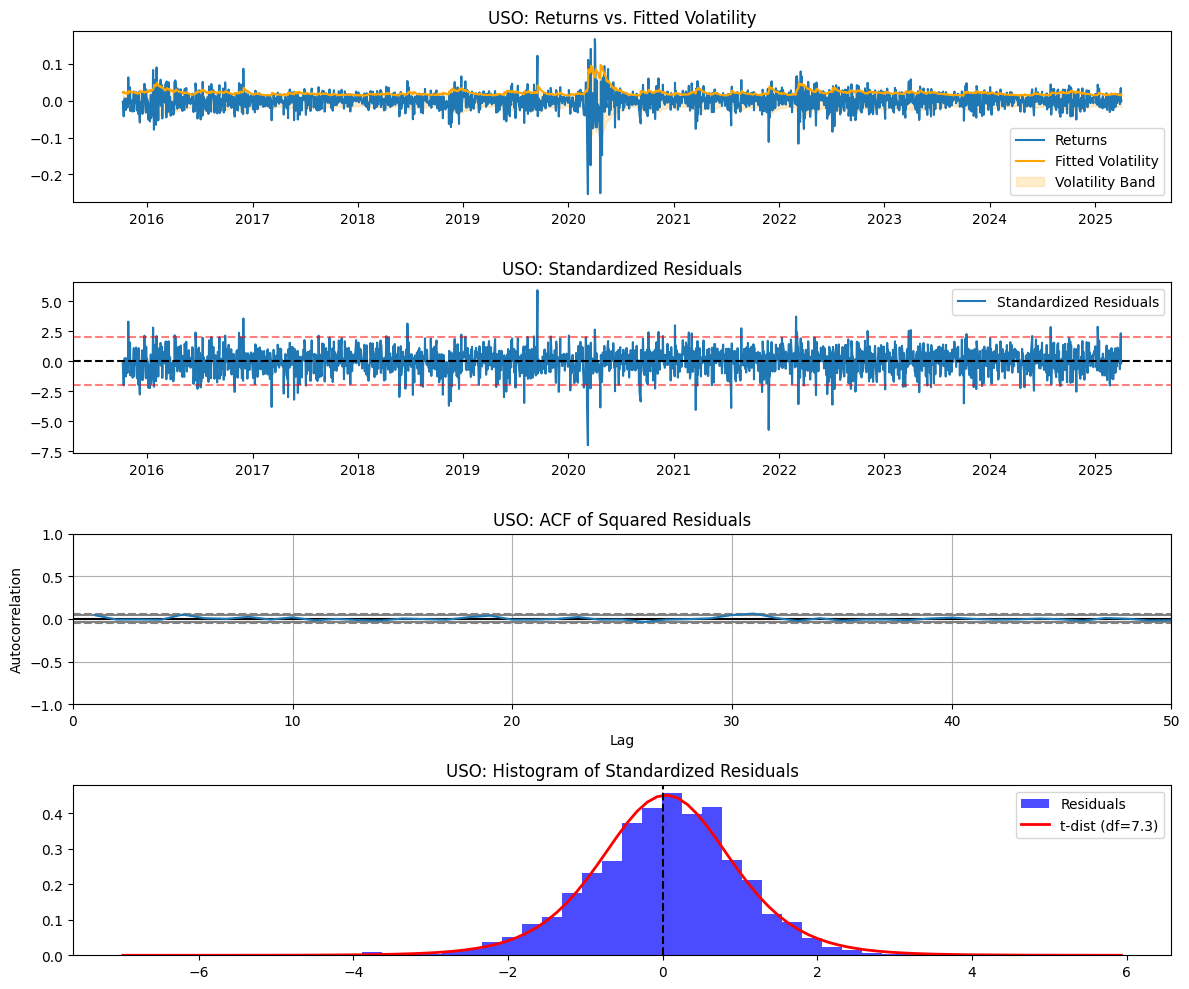

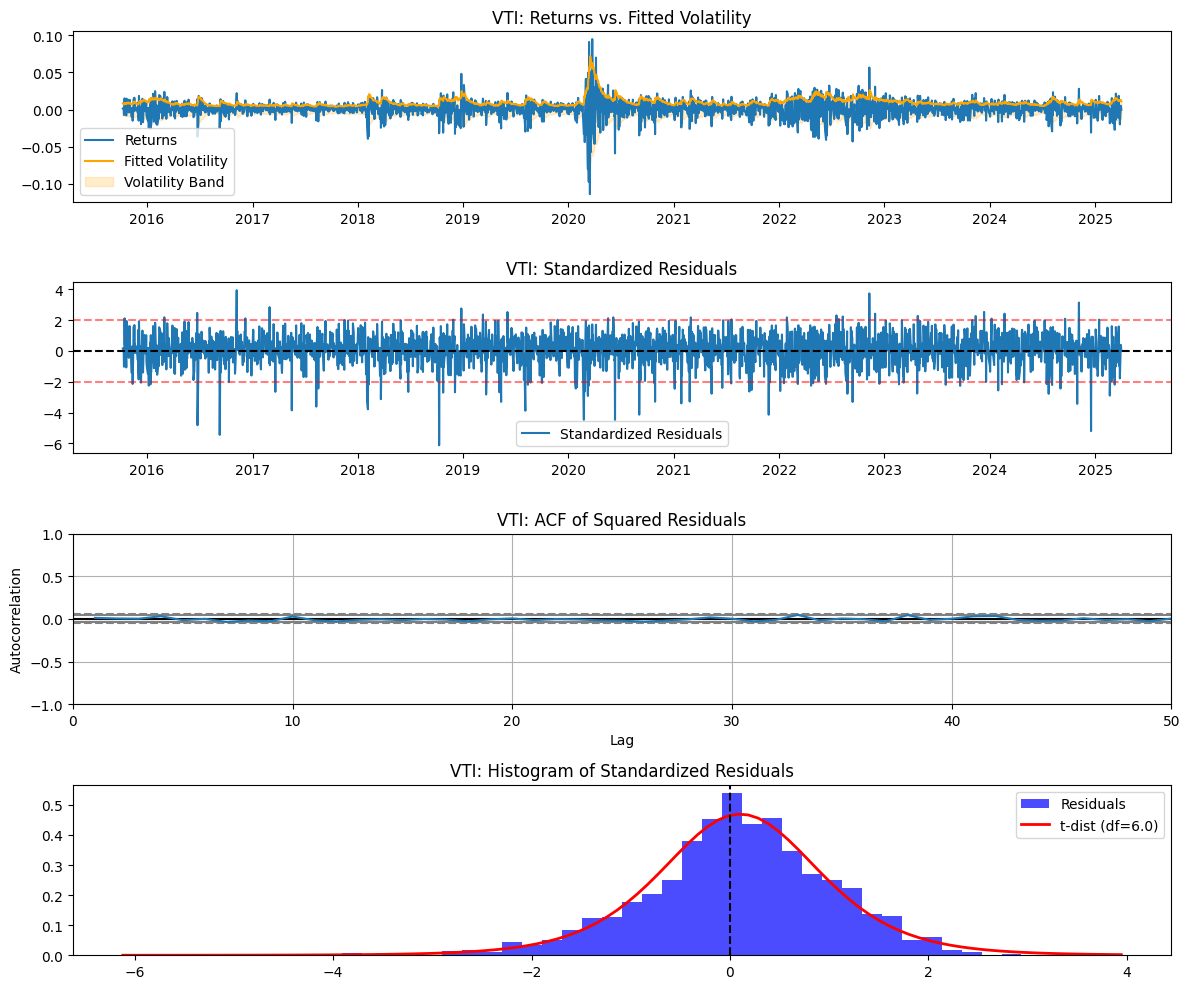

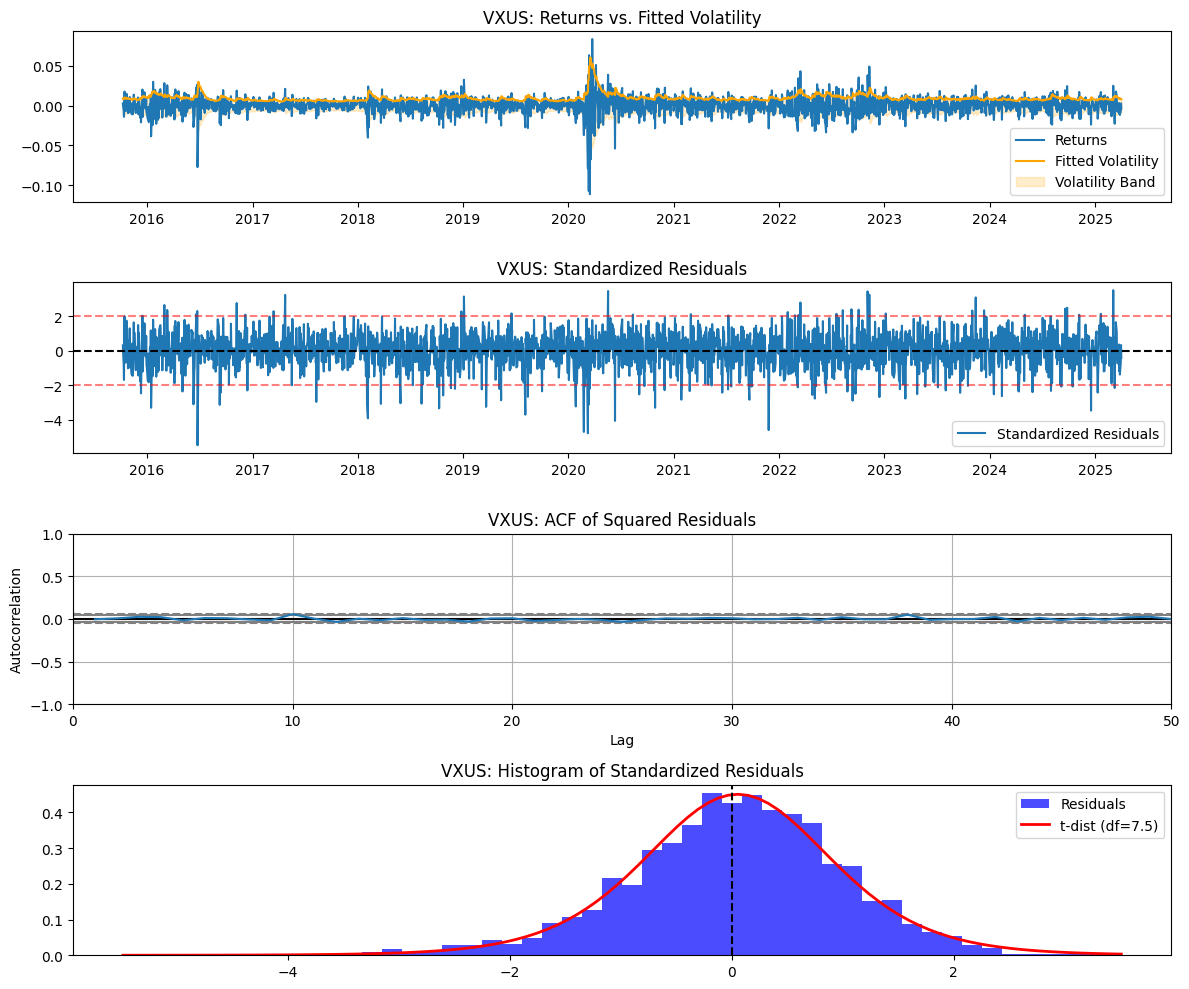

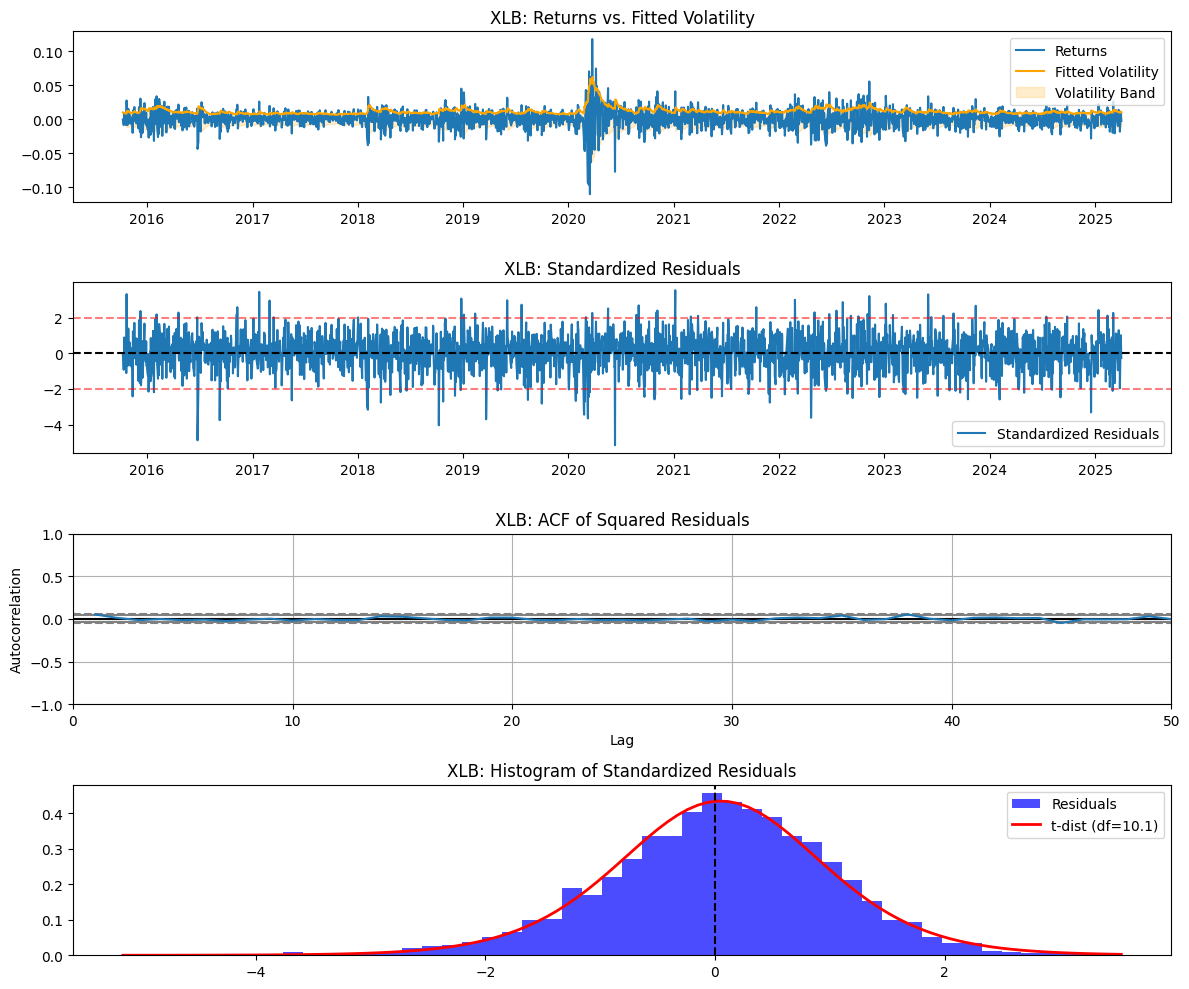

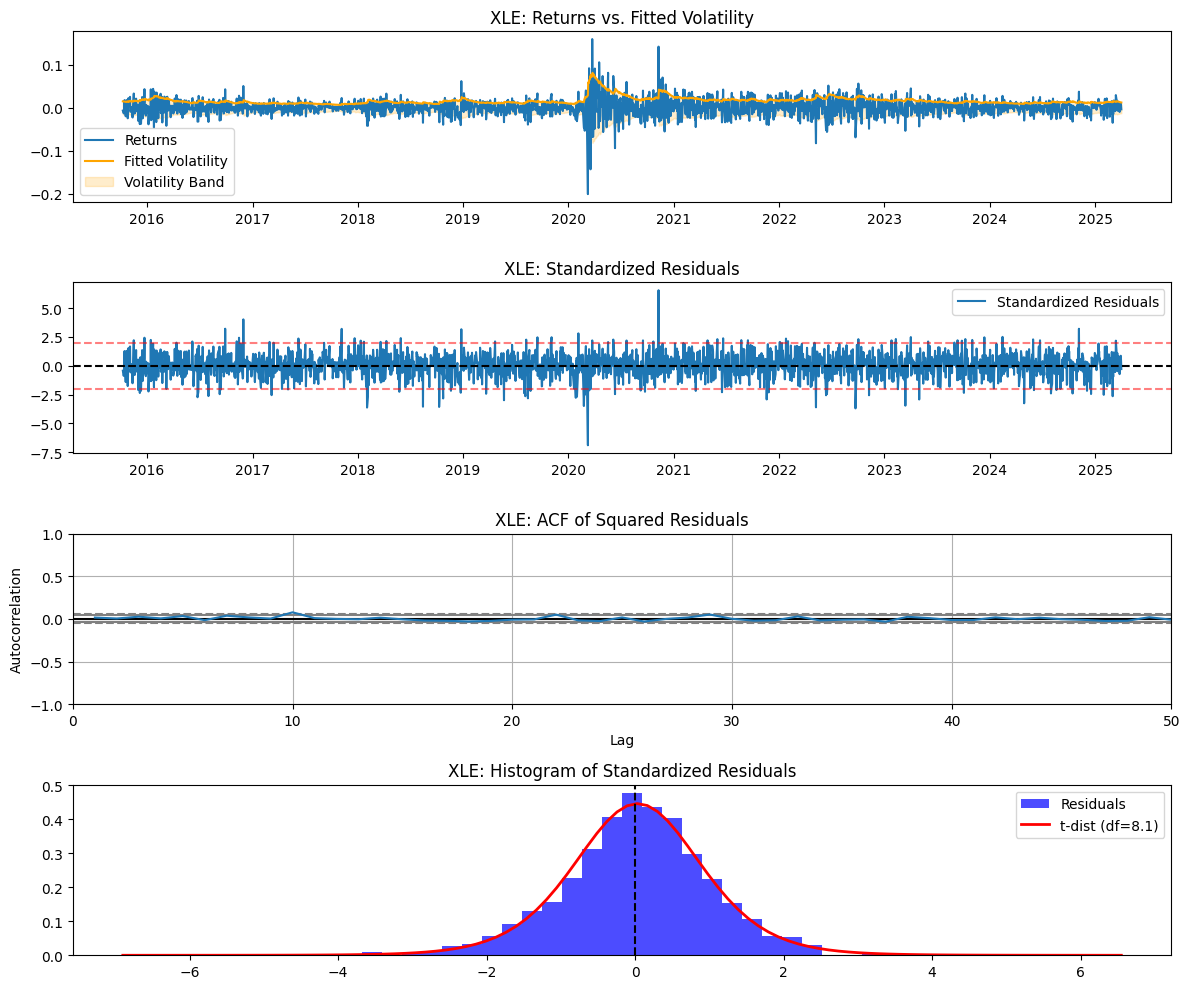

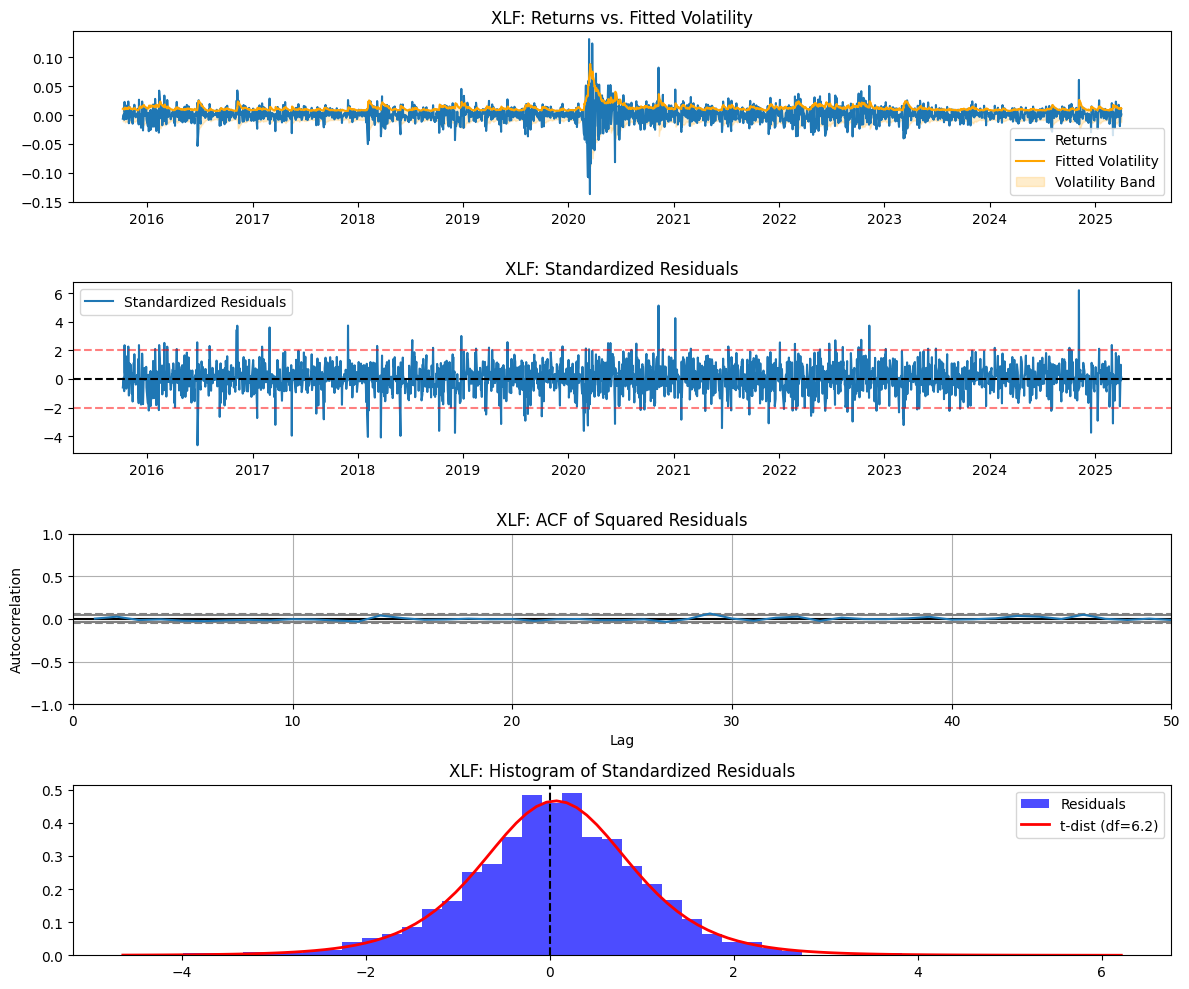

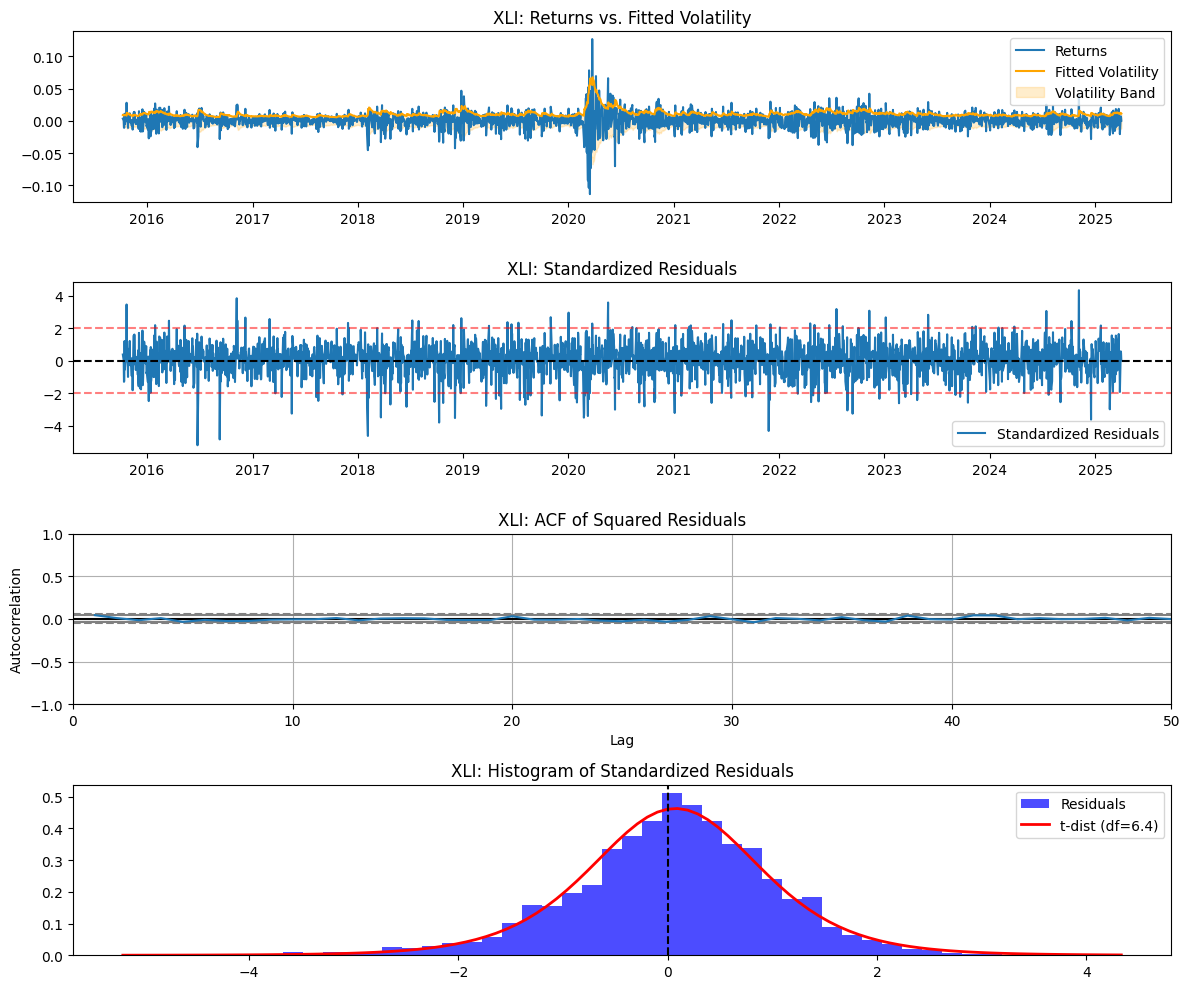

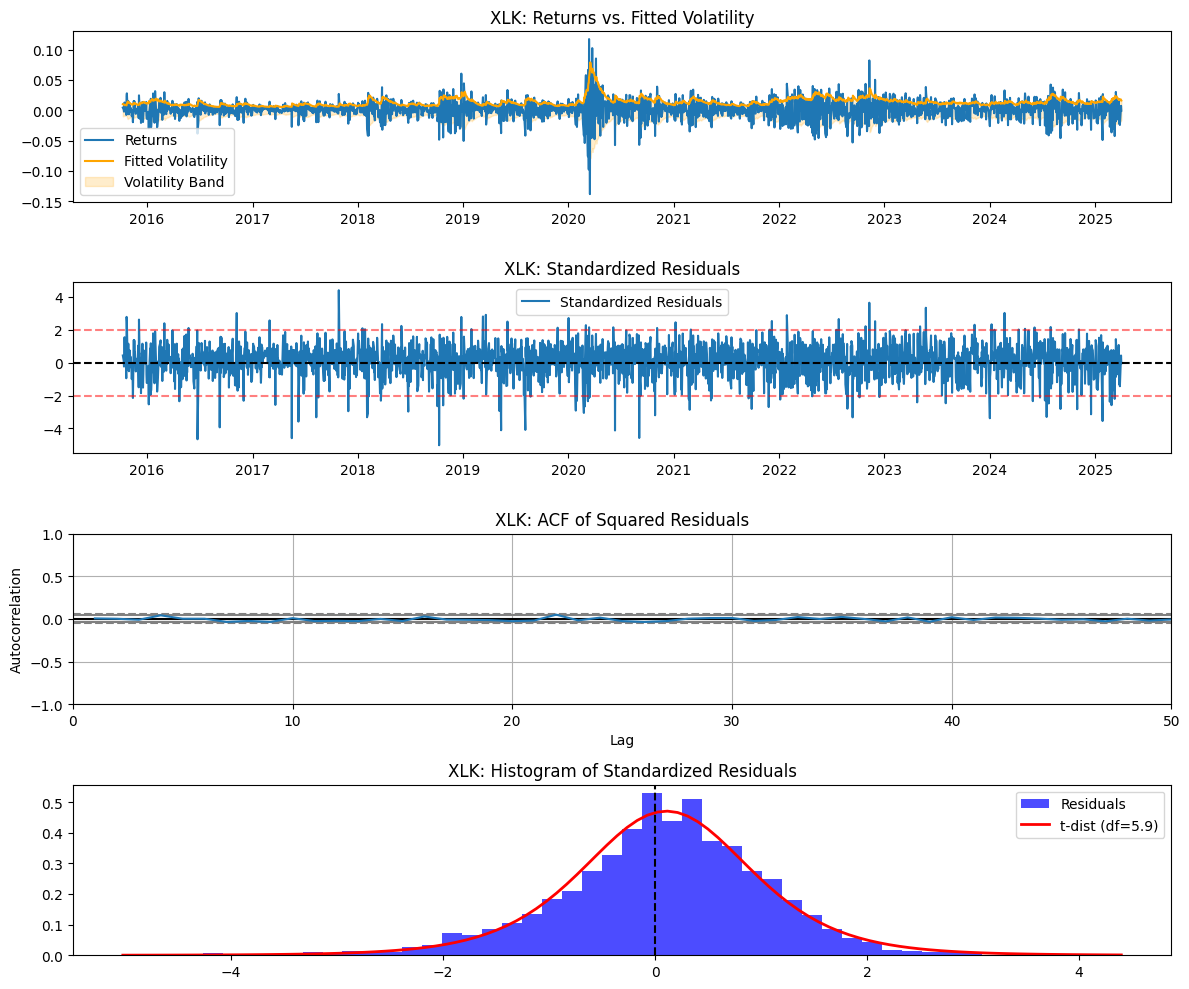

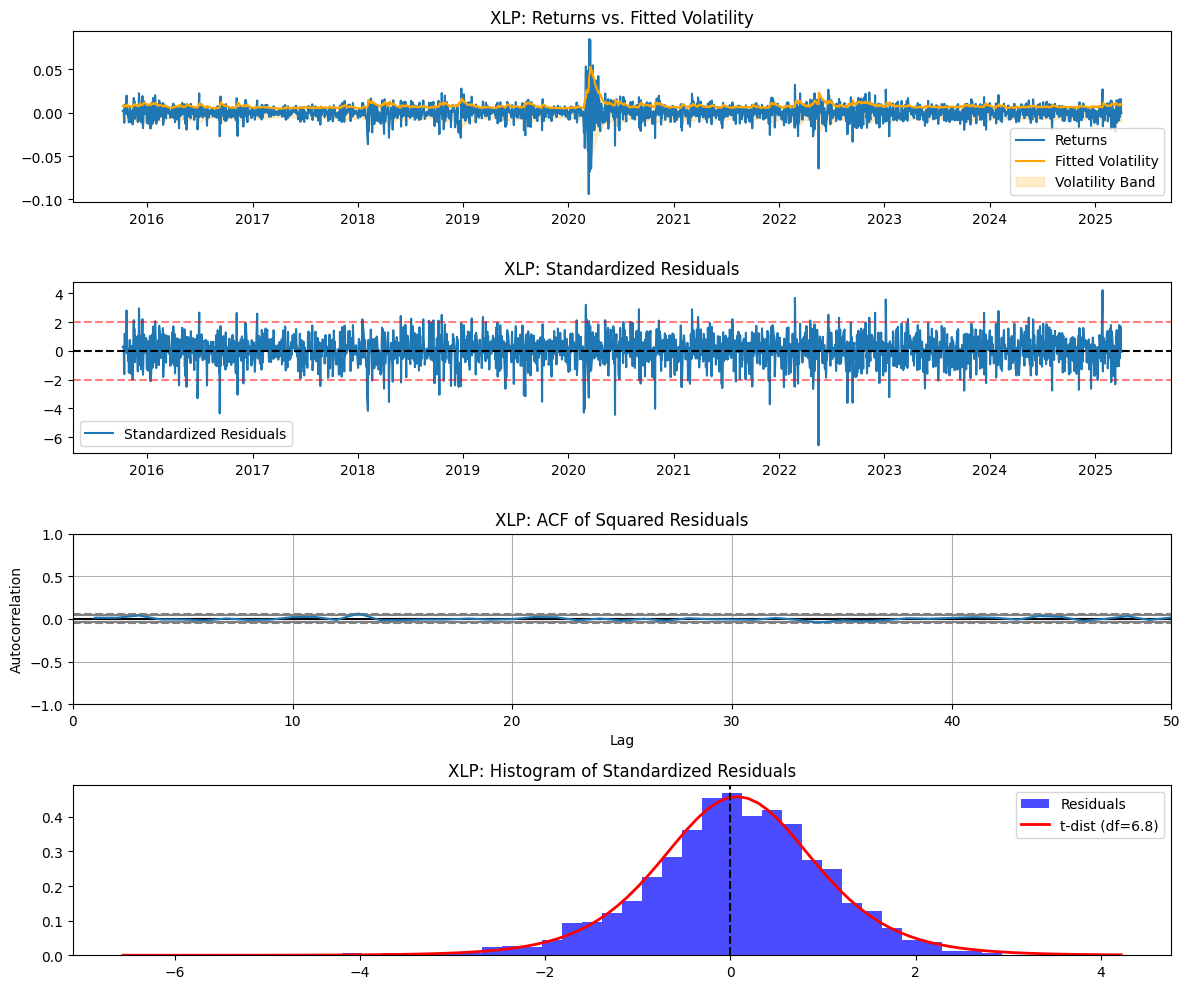

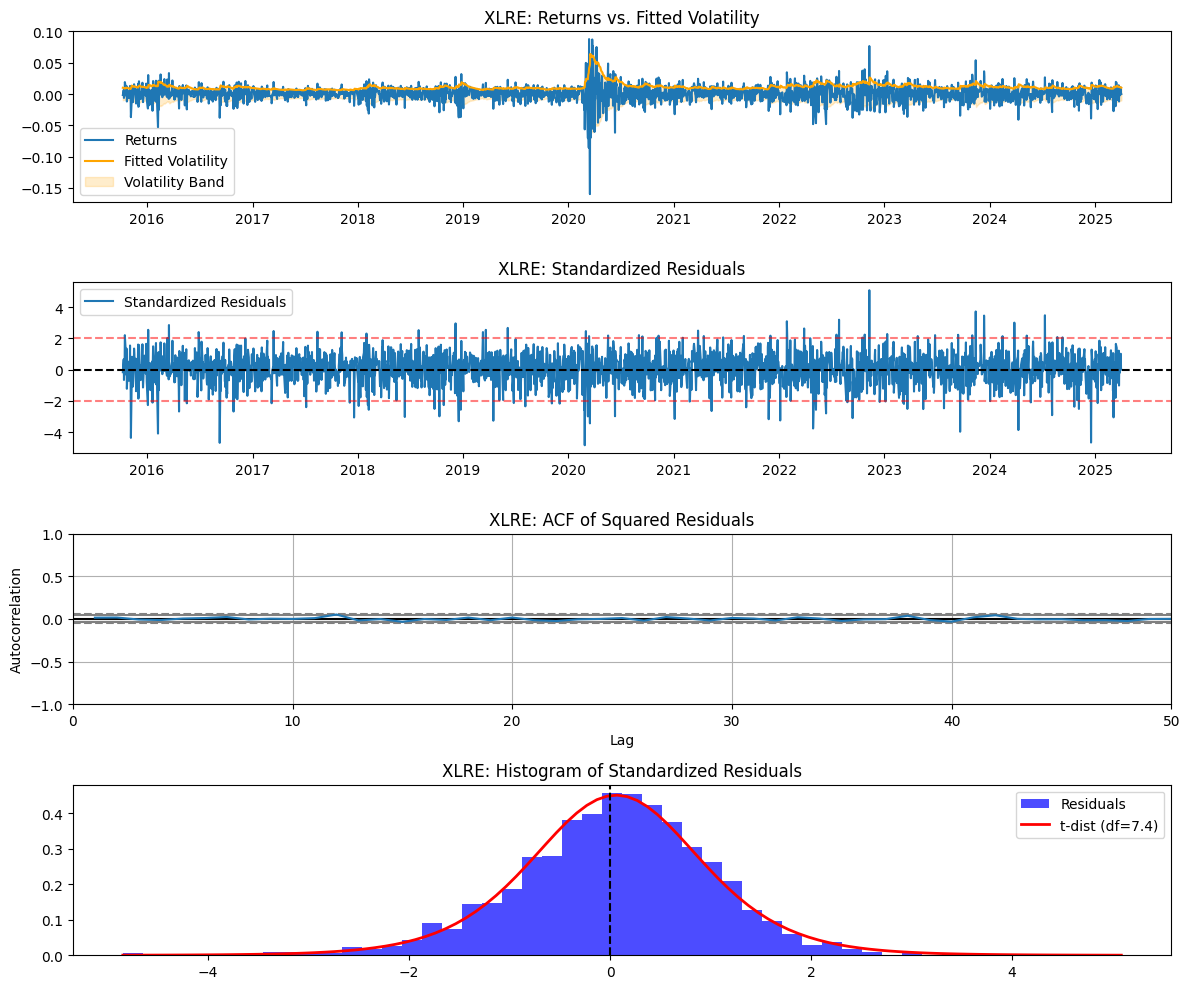

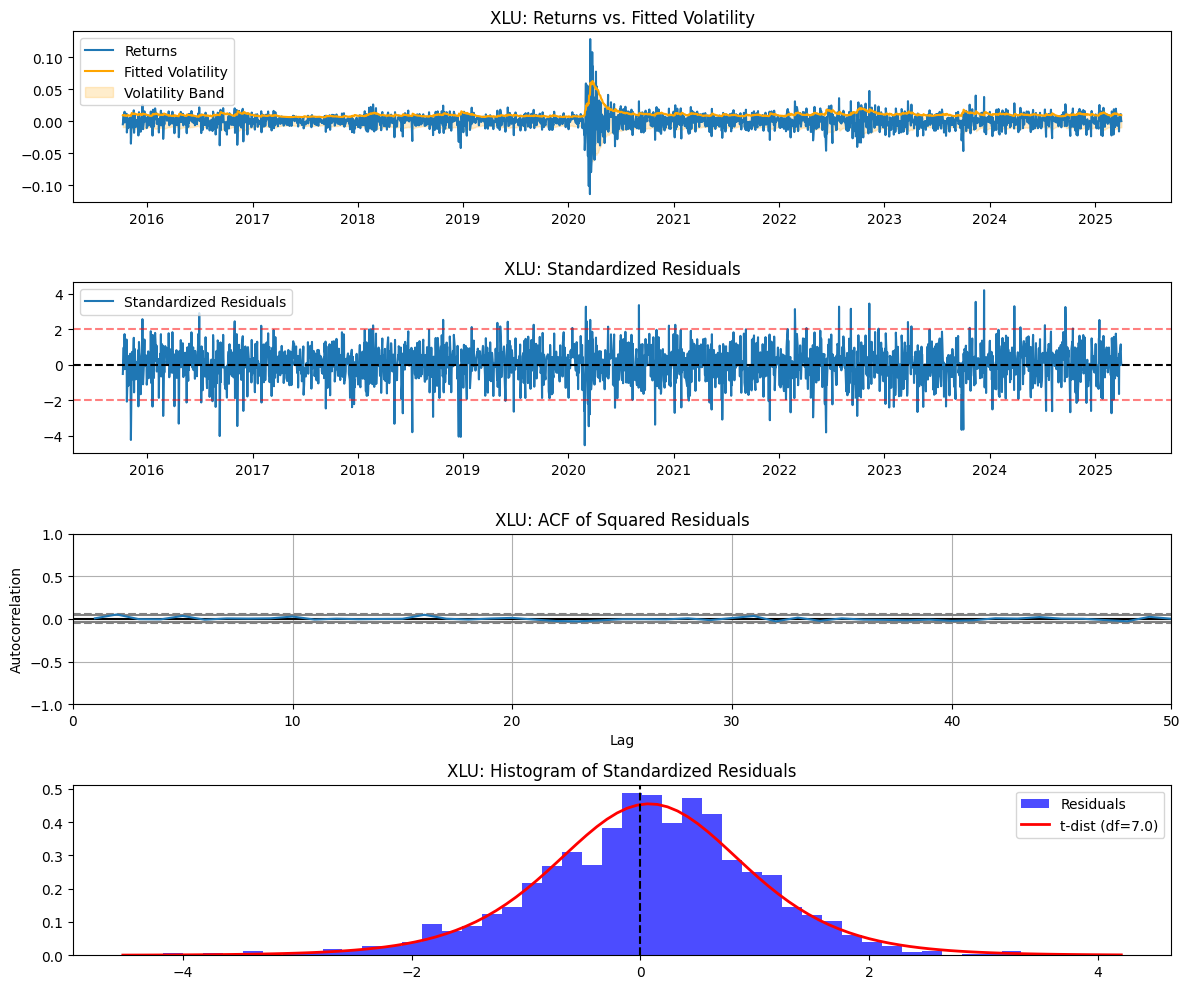

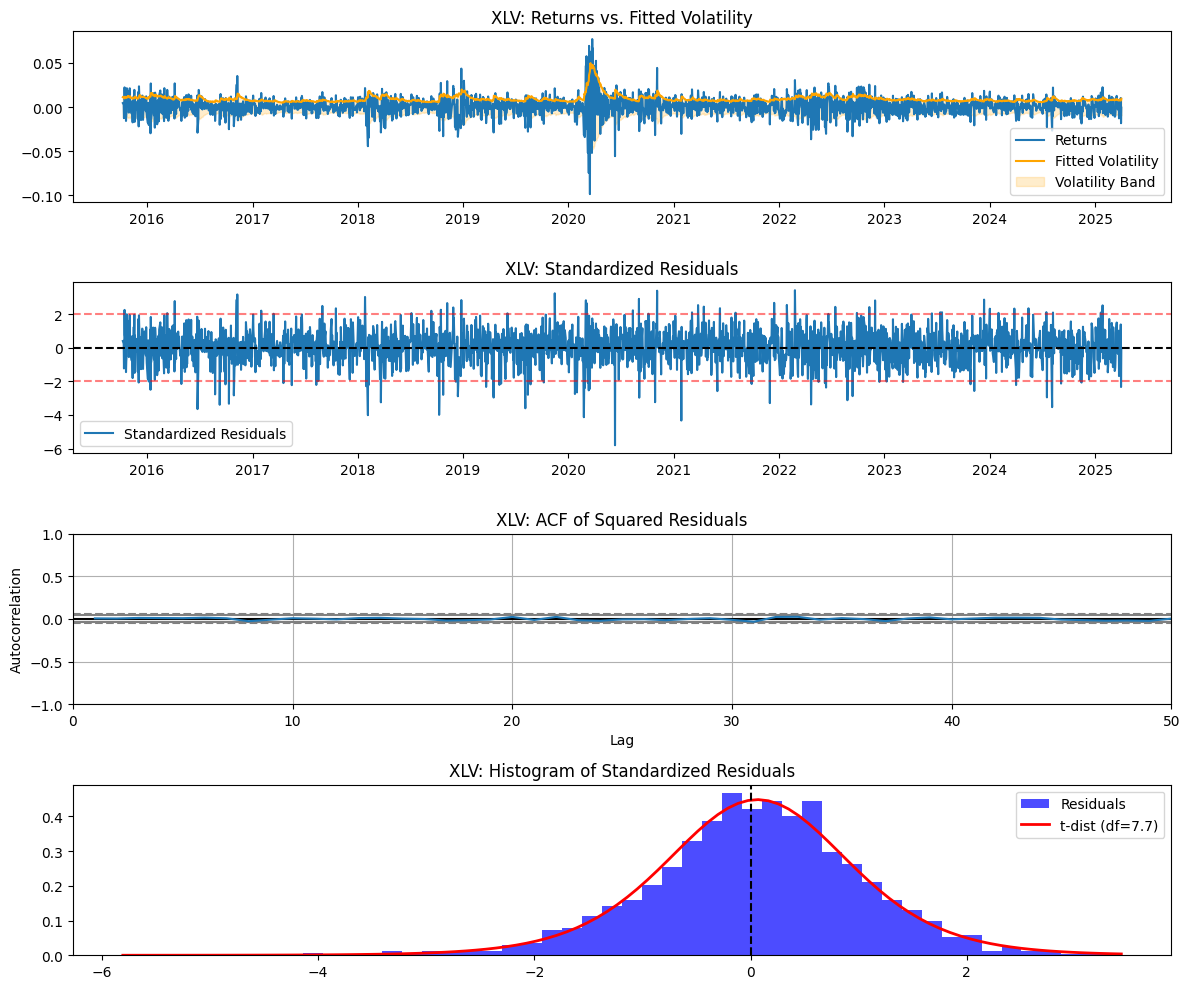

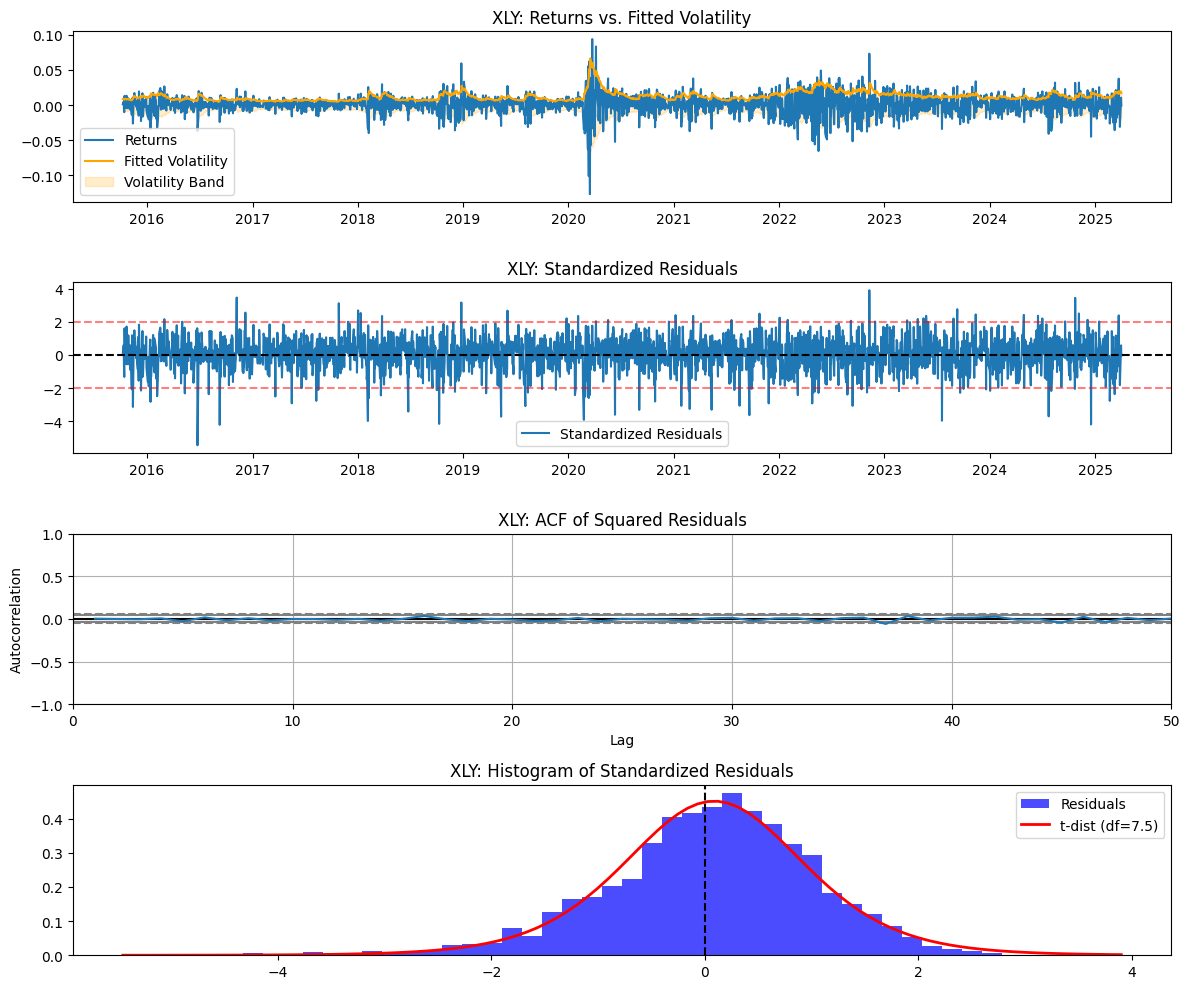

In [9]:
# Example usage

# Fit the model and time it
print("Starting DCC-GARCH fitting...")
start_time = time.time()
dcc_garch = DCC_GARCH(returns)
dcc_garch.fit()
end_time = time.time()

print(f"DCC-GARCH fitting completed in {end_time - start_time:.2f} seconds.")


# Run diagnostics
dcc_garch.diagnostics()
for i in range(len(etf_tickers)):
    dcc_garch.plot_diagnostics(ticker_idx=i)


# Display results
vols = dcc_garch.get_volatilities()
# print("Volatility Summary:")
# print(vols.describe())
corrs = dcc_garch.get_correlations()
# print("\nLast day's volatilities:")
# display(vols.iloc[-1])
# print("\nLast day's correlation matrix:")
# display(corrs[-1])

# ADCC-GARCH model
- Didn't solve the correlated residuals issue
- New parameter $g$ seems not necessary
- Performance is similar to DCC-GARCH

In [4]:
from IPython.display import display

import yfinance as yf
import pandas as pd
import numpy as np
import time

# etf_tickers = ["SPY", "QQQ", "VTI", "XLK", "IWM"]  # Correlated subset
etf_tickers = ["SPY", "TLT", "GLD", "XLE", "XLU"]  # UnCorrelated subset

df = yf.download(etf_tickers, period="max", interval="1d", auto_adjust=False)["Adj Close"]
# df = yf.download(etf_tickers, start="2021-01-01", end="2024-12-31", interval="1d", auto_adjust=False)["Adj Close"]
returns = df.pct_change().dropna()


[*********************100%***********************]  5 of 5 completed


In [5]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import yfinance as yf
from IPython.display import display
import time
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt
from arch import arch_model
import seaborn as sns
from scipy.stats import t
from scipy.stats import chi2

class DCC_GARCH:
    def __init__(self, returns):
        """Initialize DCC_GARCH with a DataFrame of asset returns."""
        self.index = returns.index
        self.returns = returns.values
        self.tickers = returns.columns
        self.n_assets = self.returns.shape[1]
        self.n_obs = self.returns.shape[0]
        self.garch_params = None
        self.dcc_params = None
        self.volatilities = None
        self.correlations = None
        self.residuals = None


    def fit_garch(self, ticker_idx):
        """Fit GARCH(1,1) to a single asset's returns."""
        returns = self.returns[:, ticker_idx]
        model = arch_model(returns, vol="Garch", p=1, q=1, rescale=True, dist="t", mean="Zero")
        res = model.fit(disp="off")
        res.params["omega"] /= (res.scale)**2
        return res
        # [res.params["omega"], res.params["alpha[1]"], res.params["beta[1]"]]


    def fit_adcc(self, residuals):
        def adcc_log_likelihood(params, residuals):
            a, b, g = params
            if a <= 0 or b <= 0 or g < 0 or a + b + g >= 1:  # Stationarity constraint
                return np.inf
            n_obs, n_assets = residuals.shape
            Q_bar = np.cov(residuals.T)  # Unconditional covariance
            Qt = np.zeros((n_obs, n_assets, n_assets))
            Rt = np.zeros((n_obs, n_assets, n_assets))
            Qt[0] = Q_bar
            log_likelihood = 0
            for t in range(1, n_obs):
                # Asymmetry term: negative residuals only
                n_t = np.where(residuals[t-1] < 0, residuals[t-1], 0)
                Qt[t] = (1 - a - b - g) * Q_bar + a * np.outer(residuals[t-1], residuals[t-1]) + b * Qt[t-1] + g * np.outer(n_t, n_t)
                diag_sqrt = np.sqrt(np.maximum(np.diag(Qt[t]), 1e-6))  # Avoid division by zero
                Rt[t] = Qt[t] / np.outer(diag_sqrt, diag_sqrt)
                Rt[t] += np.eye(n_assets) * 1e-6  # Regularization
                try:
                    chol = np.linalg.cholesky(Rt[t])
                    log_det = 2 * np.sum(np.log(np.diag(chol)))
                    z = np.linalg.solve(chol, residuals[t])
                    log_likelihood -= 0.5 * (log_det + z.T @ z)
                except np.linalg.LinAlgError:
                    return np.inf
            return -log_likelihood

        # Optimization with multiple initial guesses
        bounds = [(1e-6, 0.1), (0.7, 0.98), (0.001, 0.1)]
        initial_guesses = [[0.02, 0.96, 0.01], [0.03, 0.95, 0.02], [0.01, 0.97, 0.01]]
        best_result = None
        best_ll = np.inf
        for init in initial_guesses:
            result = minimize(adcc_log_likelihood, init, args=(residuals,), 
                            method="SLSQP", bounds=bounds, options={"ftol": 1e-8, "maxiter": 2000})
            if result.fun < best_ll:
                best_ll = result.fun
                best_result = result
        print(f"ADCC Fit Success: {best_result.success}, Message: {best_result.message}")
        return best_result.x


    def fit(self):
        """Fit the full ADCC-GARCH model."""
        print("Fitting GARCH models...")
        self.garch_params = []
        self.volatilities = np.zeros_like(self.returns)
        self.residuals = np.zeros_like(self.returns)
        for i in range(self.n_assets):
            res = self.fit_garch(i)
            params = [res.params["omega"], res.params["alpha[1]"], res.params["beta[1]"]]
            self.garch_params.append(params)
            self.volatilities[:, i] = res.conditional_volatility / res.scale
            self.residuals[:, i] = res.resid / res.conditional_volatility

        print("Fitting ADCC model...")
        self.dcc_params = self.fit_adcc(self.residuals)  # Changed from fit_dcc
        a, b, g = self.dcc_params
        Q_bar = np.cov(self.residuals.T)
        self.correlations = np.zeros((self.n_obs, self.n_assets, self.n_assets))
        Qt = np.zeros_like(self.correlations)
        Qt[0] = Q_bar
        for t in range(1, self.n_obs):
            n_t = np.where(self.residuals[t-1] < 0, self.residuals[t-1], 0)  # Asymmetry term
            Qt[t] = (1 - a - b - g) * Q_bar + a * np.outer(self.residuals[t-1], self.residuals[t-1]) + b * Qt[t-1] + g * np.outer(n_t, n_t)
            diag_sqrt = np.sqrt(np.maximum(np.diag(Qt[t]), 1e-6))
            self.correlations[t] = Qt[t] / np.outer(diag_sqrt, diag_sqrt)
            # Ensure positive definiteness
            self.correlations[t] += np.eye(self.n_assets) * 1e-6
        

    def get_volatilities(self): 
        """Return time-varying volatilities as a DataFrame."""
        if self.volatilities is None:
            raise ValueError("Model not fitted yet. Call fit() first.")
        return pd.DataFrame(self.volatilities, index=self.index, columns=self.tickers)


    def get_correlations(self):
        """Return time-varying correlation matrices as a list of DataFrames."""
        if self.correlations is None:
            raise ValueError("Model not fitted yet. Call fit() first.")
        return [pd.DataFrame(self.correlations[t], index=self.tickers, columns=self.tickers) 
                for t in range(self.n_obs)]
        
        
    def diagnostics(self):
        """Perform diagnostic checks on the model fit."""
        if self.residuals is None:
            raise ValueError("Model not fitted yet. Call fit() first.")

        print("=== Residual Sanity Check ===")
        print(f"Residuals shape: {self.residuals.shape}")
        print(f"Sample residuals (first 5 rows):")
        display(pd.DataFrame(self.residuals[:5], columns=self.tickers))

        lag_test = 10
        print("=== Univariate GARCH Diagnostics ===")
        for i, ticker in enumerate(self.tickers):
            res = self.residuals[:, i]
            mean_res = np.mean(res)
            var_res = np.var(res)
            lb_test = acorr_ljungbox(res, lags=[lag_test], return_df=True)
            lb_test_sq = acorr_ljungbox(res**2, lags=[lag_test], return_df=True)
            print(f"\n{ticker}:")
            print(f"Mean of residuals: {mean_res:.4f} (should be ~0)")
            print(f"Variance of residuals: {var_res:.4f} (should be ~1)")
            print(f"Ljung-Box test (residuals, lag {lag_test}): p-value = {lb_test['lb_pvalue'].iloc[0]:.4f}")
            print(f"Ljung-Box test (squared residuals, lag {lag_test}): p-value = {lb_test_sq['lb_pvalue'].iloc[0]:.4f}")
            print(f"omega = {self.garch_params[i][0]:.6f}, alpha = {self.garch_params[i][1]:.4f}, beta = {self.garch_params[i][2]:.4f}")
            

        print("\n=== DCC Correlation Diagnostics ===")
        print(f"ADCC Parameters [a, b, g]: {self.dcc_params}")
        # Create a matrix for p-values
        n_assets = self.n_assets
        p_value_matrix = np.ones((n_assets, n_assets))  # Default to 1 (no significance)
        for i in range(n_assets):
            for j in range(i + 1, n_assets):
                cross_prod = self.residuals[:, i] * self.residuals[:, j]
                lb_cross = acorr_ljungbox(cross_prod, lags=[lag_test], return_df=True)
                p_val = lb_cross['lb_pvalue'].iloc[0]
                p_value_matrix[i, j] = p_val
                p_value_matrix[j, i] = p_val  # Symmetric matrix
                if p_val < 0.05:
                    print(f"Significant residual cross-correlation between {self.tickers[i]} and {self.tickers[j]}: "f"p-value = {p_val:.4f}")
                    
        # Multivariate Ljung-Box Test
        print("\n=== Multivariate Ljung-Box Test ===")
        T = self.n_obs
        k = self.n_assets
        cross_prods = np.zeros((T, k, k))
        for t in range(T):
            cross_prods[t] = np.outer(self.residuals[t], self.residuals[t])

        # Compute rho_0 (lag 0 cross-correlation of cross-products)
        rho_0 = np.mean(cross_prods, axis=0)
        rho_0_inv = np.linalg.inv(rho_0)

        # Compute Q_k^*(m)
        Q_star = 0
        for i in range(1, lag_test + 1):
            # Compute rho_i (lag i cross-correlation)
            rho_i = np.zeros((k, k))
            for t in range(i, T):
                rho_i += np.outer(self.residuals[t], self.residuals[t-i])
            rho_i /= (T - i)

            # Vectorize rho_i
            b_i = rho_i.flatten()

            # Compute (rho_0^-1 ⊗ rho_0^-1)
            rho_0_inv_kron = np.kron(rho_0_inv, rho_0_inv)

            # Add to Q_star
            Q_star += (T**2 / (T - i)) * (b_i.T @ rho_0_inv_kron @ b_i)

        # Degrees of freedom: k^2 * m
        df = k**2 * lag_test
        p_value = 1 - chi2.cdf(Q_star, df)
        print(f"Multivariate Ljung-Box Q*({lag_test}): {Q_star:.2f}, df = {df}, p-value = {p_value:.4f}")
                    
        # Heatmap of p-values
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            p_value_matrix,
            annot=True,  # Show p-values in cells
            fmt=".4f",   # 4 decimal places
            cmap="RdYlGn",  # Red (low p) to Green (high p), reversed
            vmin=0, vmax=1,  # p-value range
            xticklabels=self.tickers,
            yticklabels=self.tickers,
            square=True
        )
        plt.title(f"DCC Residual Cross-Correlation P-Values (Lag {lag_test})")
        plt.show()
        
        print("\n=== Average Correlation Matrix ===")
        avg_corr = np.mean([self.correlations[t] for t in range(self.n_obs)], axis=0)
        display(pd.DataFrame(avg_corr, index=self.tickers, columns=self.tickers).round(4))


    def plot_diagnostics(self, ticker_idx=0):
        """Plot diagnostics for a specific asset, including histogram of standardized residuals."""
        ticker = self.tickers[ticker_idx]
        res = self.residuals[:, ticker_idx]
        vols = self.volatilities[:, ticker_idx]
        rets = self.returns[:, ticker_idx]

        # Fit t-distribution to residuals
        df, loc, scale = t.fit(res)  # Degrees of freedom, location (mean), scale (std)
        
        plt.figure(figsize=(12, 10))  # Increased height for 4 subplots

        # Subplot 1: Returns vs. Fitted Volatility
        plt.subplot(4, 1, 1)
        plt.plot(self.index, rets, label="Returns")
        plt.plot(self.index, vols, label="Fitted Volatility", color="orange")
        plt.fill_between(self.index, -vols, vols, color="orange", alpha=0.2, label="Volatility Band")
        plt.title(f"{ticker}: Returns vs. Fitted Volatility")
        plt.legend()

        # Subplot 2: Standardized Residuals Time Series
        plt.subplot(4, 1, 2)
        plt.plot(self.index, res, label="Standardized Residuals")
        plt.axhline(0, color="black", linestyle="--")
        plt.axhline(2, color="red", linestyle="--", alpha=0.5)
        plt.axhline(-2, color="red", linestyle="--", alpha=0.5)
        plt.title(f"{ticker}: Standardized Residuals")
        plt.legend()

        # Subplot 3: ACF of Squared Residuals
        plt.subplot(4, 1, 3)
        pd.plotting.autocorrelation_plot(res**2)
        plt.xlim(0, 50)
        plt.title(f"{ticker}: ACF of Squared Residuals")

        # Subplot 4: Histogram of Standardized Residuals
        plt.subplot(4, 1, 4)
        plt.hist(res, bins=50, density=True, alpha=0.7, color="blue", label="Residuals")
        x = np.linspace(min(res), max(res), 100)
        plt.plot(x, t.pdf(x, df, loc, scale), "r-", lw=2, label=f"t-dist (df={df:.1f})")
        plt.axvline(0, color="black", linestyle="--")
        plt.title(f"{ticker}: Histogram of Standardized Residuals")
        plt.legend()

        plt.tight_layout()
        plt.show()


    def plot_all_residuals(self):
        plt.figure(figsize=(12, 6))
        for i, ticker in enumerate(self.tickers):
            plt.plot(self.index, self.residuals[:, i], label=ticker, alpha=0.7)
        plt.axhline(0, color="black", linestyle="--")
        plt.axhline(2, color="red", linestyle="--", alpha=0.5)
        plt.axhline(-2, color="red", linestyle="--", alpha=0.5)
        plt.title("Standardized Residuals for All ETFs (ADCC)")
        plt.legend()
        plt.show()

Starting DCC-GARCH fitting...
Fitting GARCH models...
Fitting ADCC model...


/Users/chakkwantse/miniconda3/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


ADCC Fit Success: True, Message: Optimization terminated successfully
DCC-GARCH fitting completed in 24.99 seconds.
=== Residual Sanity Check ===
Residuals shape: (5130, 5)
Sample residuals (first 5 rows):


Ticker       GLD       SPY       TLT       XLE       XLU
0       1.062389 -1.961040 -1.185379  0.953685 -0.442981
1       0.445039  0.704384  0.763451  1.269791  1.967595
2      -0.529316  0.229329  0.183330  0.482517  0.680595
3       0.807732  0.373931  0.000000  0.663103  0.405664
4       0.644760 -0.124834 -1.012262  0.345197  0.459410

=== Univariate GARCH Diagnostics ===

GLD:
Mean of residuals: 0.0425 (should be ~0)
Variance of residuals: 0.9876 (should be ~1)
Ljung-Box test (residuals, lag 10): p-value = 0.9522
Ljung-Box test (squared residuals, lag 10): p-value = 0.1849
omega = 0.000001, alpha = 0.0429, beta = 0.9518

SPY:
Mean of residuals: 0.0466 (should be ~0)
Variance of residuals: 0.9911 (should be ~1)
Ljung-Box test (residuals, lag 10): p-value = 0.1077
Ljung-Box test (squared residuals, lag 10): p-value = 0.2237
omega = 0.000002, alpha = 0.1329, beta = 0.8615

TLT:
Mean of residuals: 0.0221 (should be ~0)
Variance of residuals: 1.0017 (should be ~1)
Ljung-Box test (residuals, lag 10): p-value = 0.2693
Ljung-Box test (squared residuals, lag 10): p-value = 0.1080
omega = 0.000001, alpha = 0.0544, beta = 0.9403

XLE:
Mean of residuals: 0.0232 (should be ~0)
Variance of residuals: 1.0046 (should be ~1)
Ljung-Box test (residuals, lag 10): p-value = 0.5888
Ljung-Box test (squared residuals, lag 10): p-value = 0.

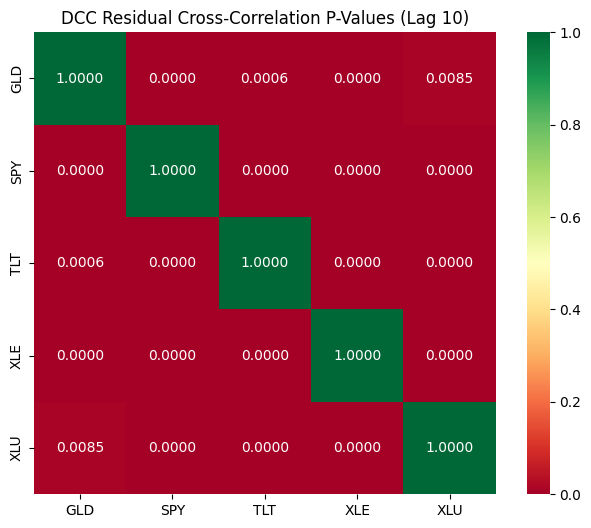


=== Average Correlation Matrix ===


Ticker     GLD     SPY     TLT     XLE     XLU
Ticker                                        
GLD     0.9998  0.0740  0.2085  0.1838  0.1476
SPY     0.0740  0.9998 -0.2396  0.6300  0.5031
TLT     0.2085 -0.2396  0.9998 -0.2611  0.0456
XLE     0.1838  0.6300 -0.2611  0.9998  0.3678
XLU     0.1476  0.5031  0.0456  0.3678  0.9998

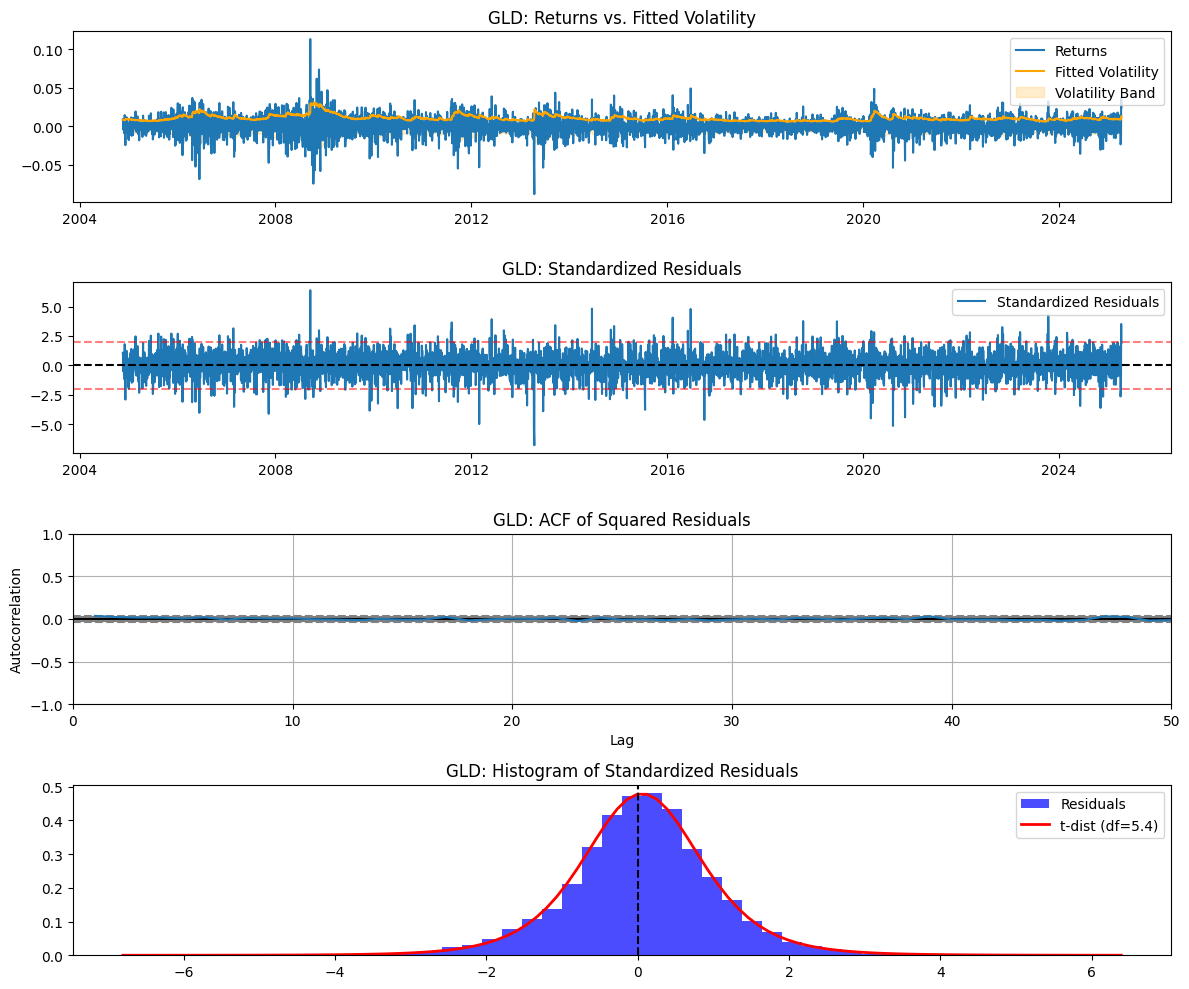

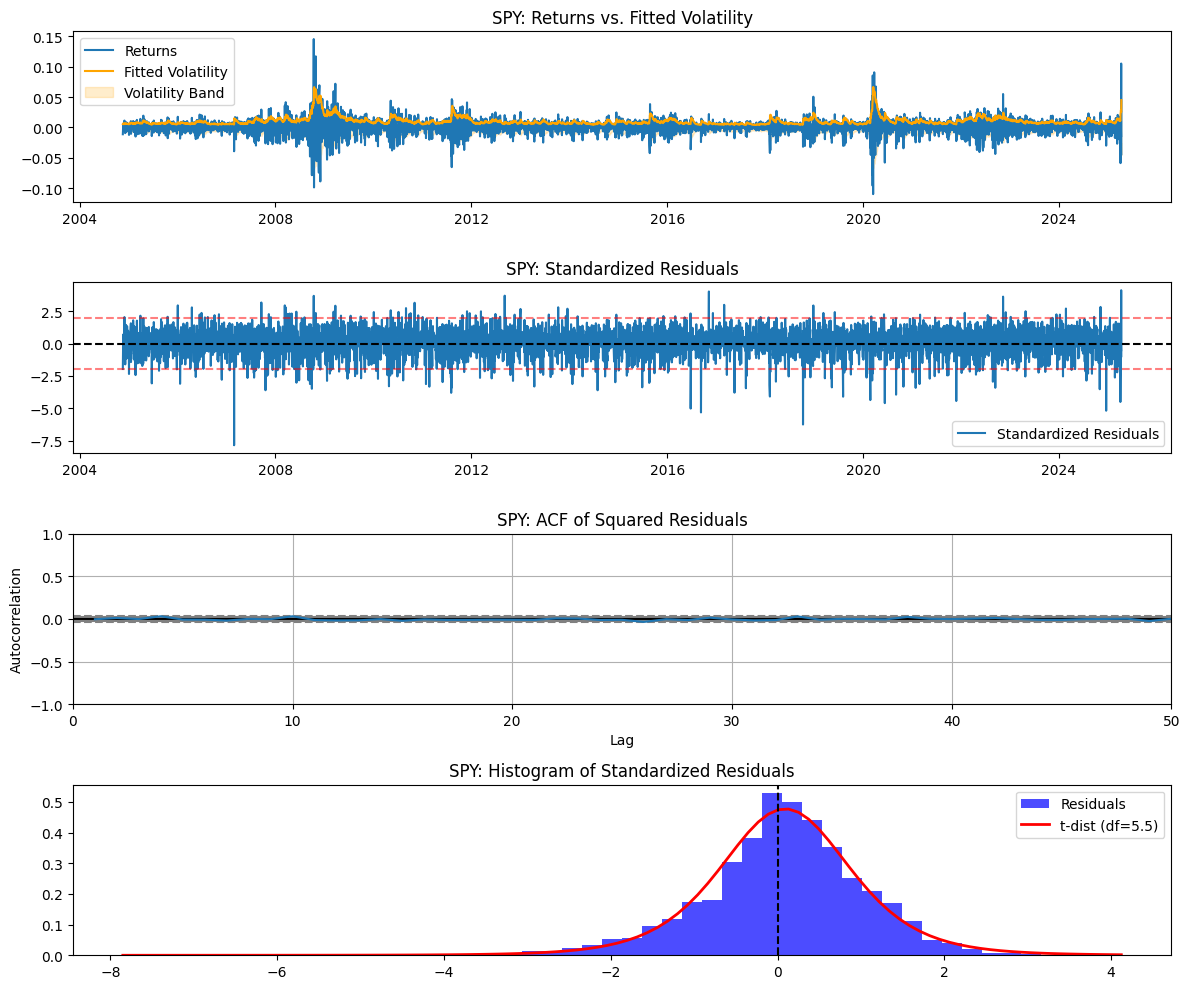

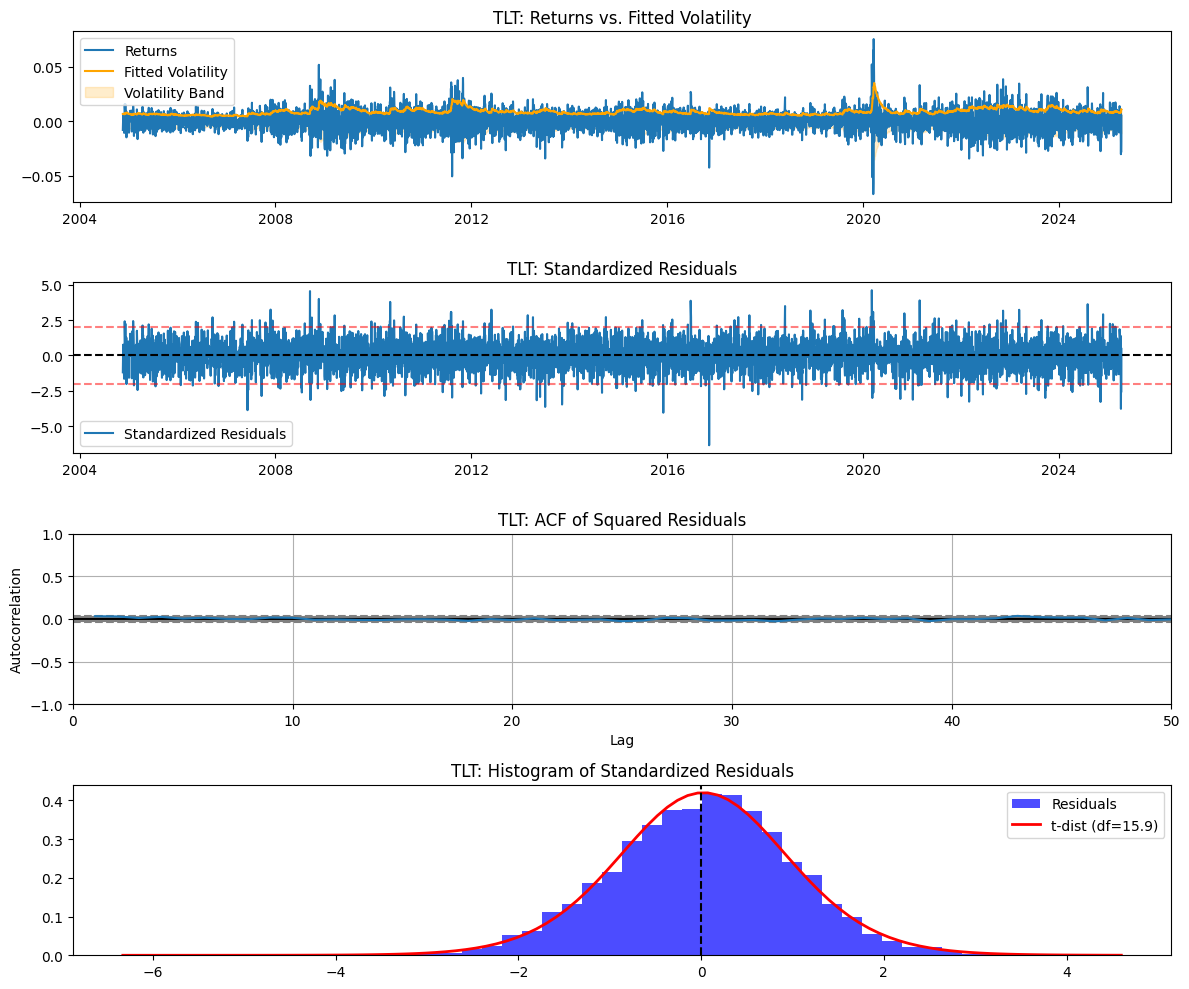

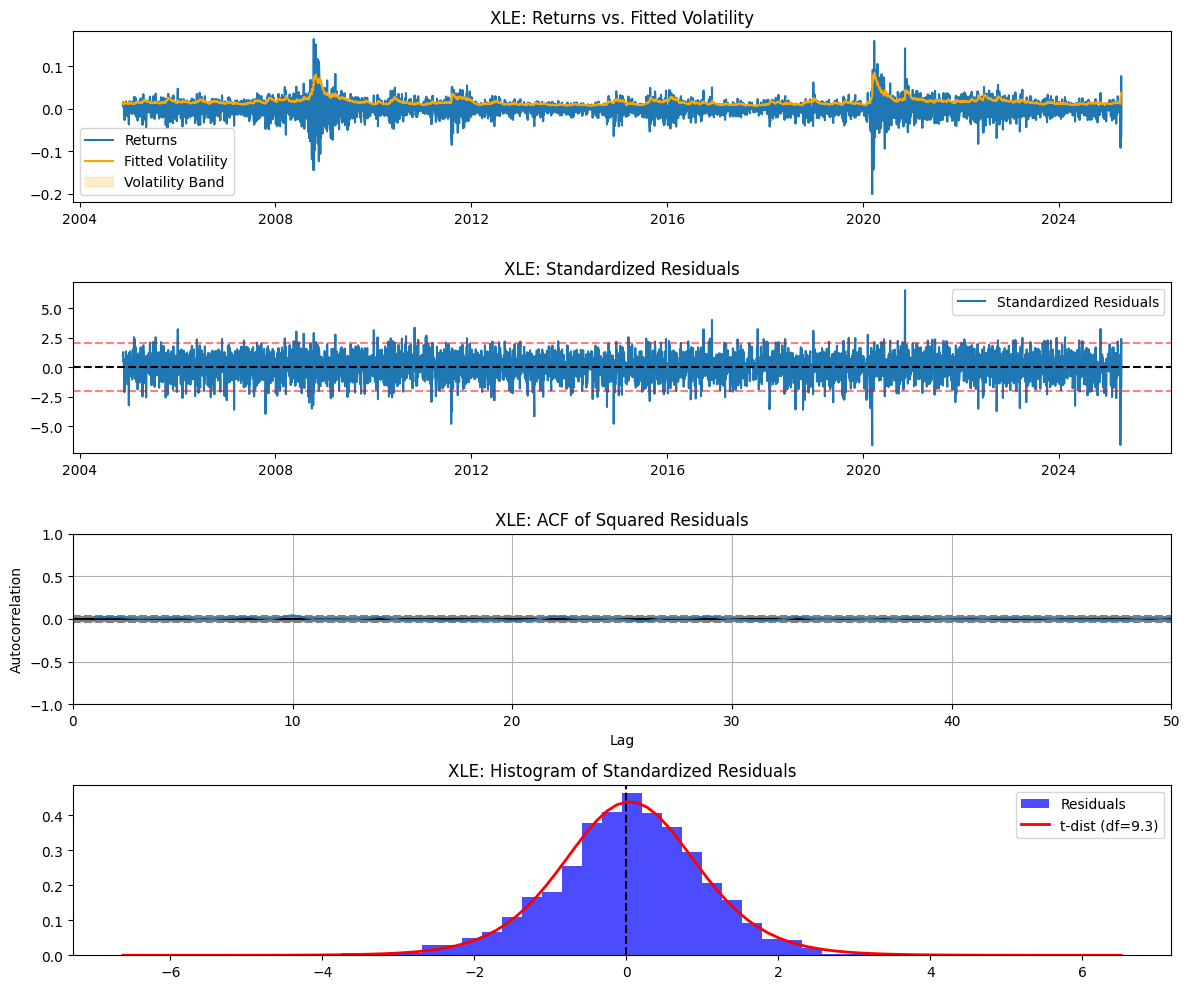

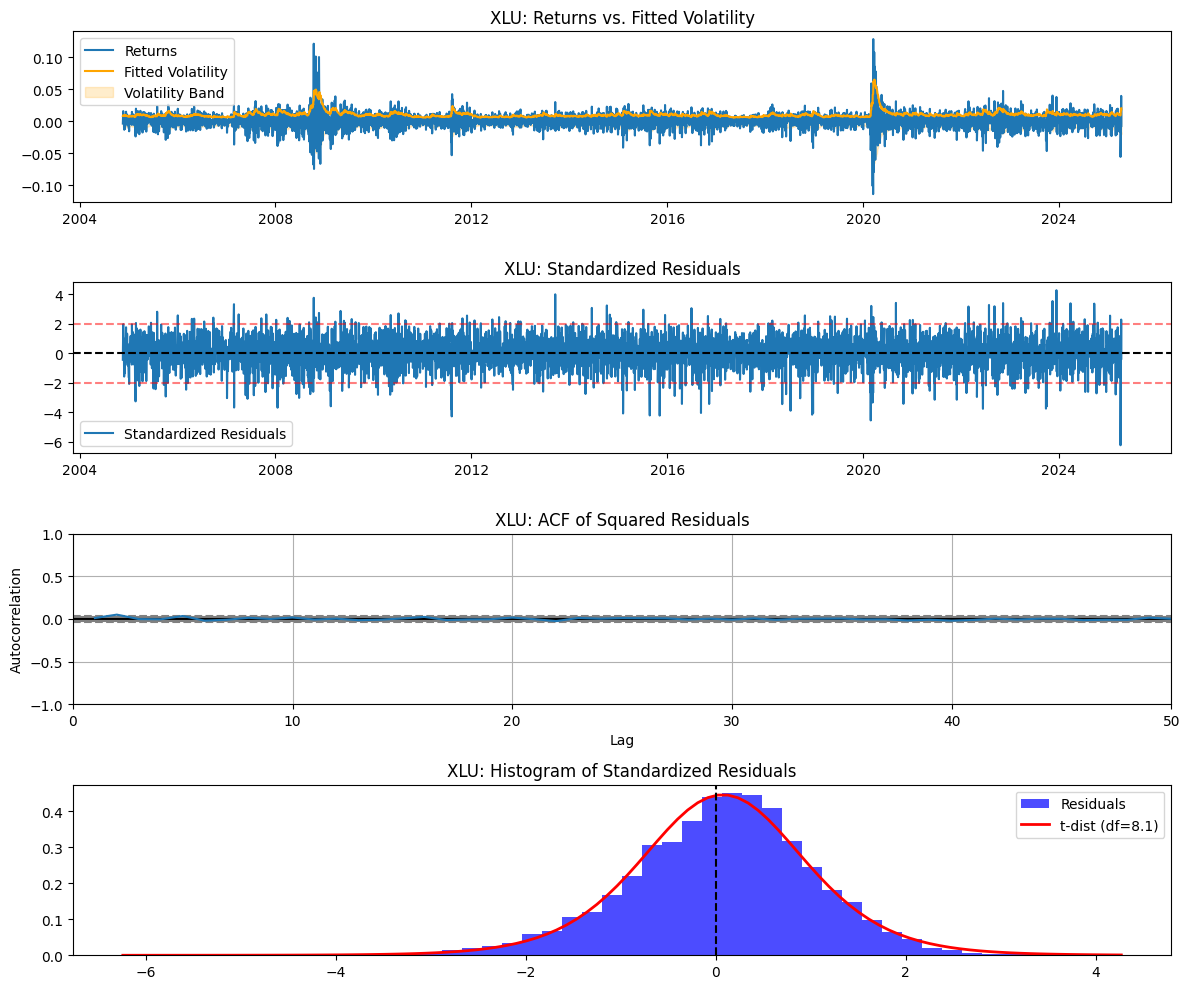

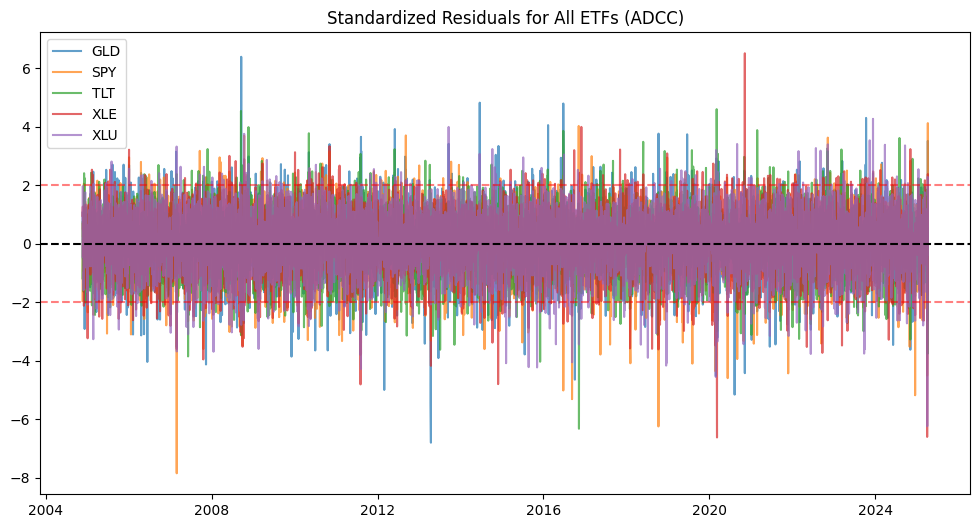

In [6]:
# Example usage

# Fit the model and time it
print("Starting DCC-GARCH fitting...")
start_time = time.time()
dcc_garch = DCC_GARCH(returns)
dcc_garch.fit()
end_time = time.time()

print(f"DCC-GARCH fitting completed in {end_time - start_time:.2f} seconds.")


# Run diagnostics
dcc_garch.diagnostics()
for i in range(len(etf_tickers)):
    dcc_garch.plot_diagnostics(ticker_idx=i)
dcc_garch.plot_all_residuals()

# Display results
vols = dcc_garch.get_volatilities()
# print("Volatility Summary:")
# print(vols.describe())
corrs = dcc_garch.get_correlations()
# print("\nLast day's volatilities:")
# display(vols.iloc[-1])
# print("\nLast day's correlation matrix:")
# display(corrs[-1])